# CAPSTONE PROJECT
# SMART METERS - BEING CONNECTED
### Submitted By - Anna Maria

## BUSINESS UNDERSTANDING
### ABSTRACT
With meter data analytics, utilities are recognizing the true value of their Smart Grid investment: Data.Smart Meter Analytics enables the utility industry to help consumers understand their usage patterns and billing, manage power quality, improve real-time power management and plan for future usage. The goal of this project is to understand usage patterns, segment customers by electrical consumption (High/Moderate/Low), correlate between weather - usage and forecast the electricity consumption of a household. Identified segments and predictions will enable utility companies to prepare specific campaigns or tariffs and electricity supply-demand more efficiently.

###  PROBLEM STATEMENT
 Analyze smart meter event data, to generate value by improving customer experience, grid reliability, operational efficiency, and revenue assurance. Based on the analysis build a system to segment the daily consumption patterns, find a correlation between weather/electrical consumption, categorize customers based on the population groups and the electricity utilization and forecast the future consumptions for a single household.
 
### BENEFITS
1.	Gives utilities the advantage of identifying unique groups to effectively target.
2.	Forecasting facilitates planning which helps in the analysis to make better decisions.
3.	Reducing energy demand as part of demand response earns you revenue incentives to offset energy costs.


### APPROACH
The planned methodology for this project is to use the CRISP-DM approach. The key steps in this methodology as listed as: -
1.	Business Understanding
2.	Data Understanding
3.	Data Preparation
4.	Modeling
5.	Evaluation
6.	Deployment

In [1]:
#IMPORT THE PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dask.dataframe as dd
import statsmodels.api as sm
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
from sklearn import preprocessing
from math import sqrt
import math
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## DATA UNDERSTANDING
### DATASET
The dataset is a reduced version of the actual UK dataset that contains the energy consumption readings for a sample of 5,567 London Households. Files provided for this dataset:

•	informations_households.csv: This file contains all the information on the households in the panel (their acorn group, their tariff) and to which block they belong to. This group is to classify the population based on the various demographic categories.

•	weather_hourly_darksky.csv: The hourly weather data of the location

•	halfhourly_dataset.zip: Zip file that contains the block files with the half-hourly smart meter measurement


What is Acorn?
Acorn is a geodemographic segmentation of the UK’s population. It segments households,postcodes and neighbourhoods into 6
categories, 18 groups and 62 types. By analysing significant social factors and population behaviour, it provides precise information and an in-depth understanding of the different types of people. 

In this dataset the 4 categories that we will be using for our analysis are:

1) Affluent Achievers - A-Lavish Lifestyles,B-Executive Wealth,C-Mature Money

2) Rising Prosperity - D-City Sophisticates,E-Career Climbers

3) Comfortable - F-Countryside Communities,G-Successful Suburbs,H-Steady Neighbourhoods,I-Comfortable Seniors,J-Starting Out

4) Adversity - O-Young Hardship,P-Struggling Estates,Q-Difficult Circumstances

5) Not known 

For this capstone i have converted the hourly data to a daily data as the number of rows is approximately 3.2 million.

## DATA PREPARATION
As i am using google cloud for this project i have created a google cloud bucket to store the data and will be using a dask dataframe to first extract the dataset and then process it using pandas dataframes. Dask dataframes are best used when we need parallel processing of the datasets.

#### LOAD THE DATASET

In [3]:
#LOAD THE DATASET - FIRST USE DASK TO LOAD FROM THE GOOGLE BUCKET
info_house_df = dd.read_csv('gs://smartmeterscap/Data/informations_households.csv')
weather_hourly_df = dd.read_csv('gs://smartmeterscap/Data/weather_hourly_darksky.csv')
hourly_meter_df = dd.read_csv('gs://smartmeterscap/Data/halfhourly_dataset/halfhourly_dataset/*.csv') 

#LOAD ALL THE DASK DATAFRAMES TO A PANDAS DATAFRAME
info_house = info_house_df.compute()
hourly_weather = weather_hourly_df.compute()
hourly_meter_red = hourly_meter_df.compute()

#### PREPROCESS THE DATA

Load the dataset and check for some basic information like datatypes, count of the rows and columns, also check for the overall summary of the dataframes.

In [4]:
#CHECK THE DATATYPE AND COUNT OF ALL THE DATAFRAMES
print(info_house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5566 entries, 0 to 5565
Data columns (total 5 columns):
LCLid            5566 non-null object
stdorToU         5566 non-null object
Acorn            5566 non-null object
Acorn_grouped    5566 non-null object
file             5566 non-null object
dtypes: object(5)
memory usage: 217.5+ KB
None


In [5]:
print(hourly_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21165 entries, 0 to 21164
Data columns (total 12 columns):
visibility             21165 non-null float64
windBearing            21165 non-null int64
temperature            21165 non-null float64
time                   21165 non-null object
dewPoint               21165 non-null float64
pressure               21152 non-null float64
apparentTemperature    21165 non-null float64
windSpeed              21165 non-null float64
precipType             21165 non-null object
icon                   21165 non-null object
humidity               21165 non-null float64
summary                21165 non-null object
dtypes: float64(7), int64(1), object(4)
memory usage: 1.9+ MB
None


In [6]:
print(hourly_meter_red.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167817021 entries, 0 to 236848
Data columns (total 3 columns):
LCLid             object
tstp              object
energy(kWh/hh)    object
dtypes: object(3)
memory usage: 5.0+ GB
None


Pandas dataframe usually assigns the type of data based on the values in the various columns, but it may not be able to identify all the datatypes, for example dates, time etc. So I may have to update these columns according to the values which i will take care in the pre processing part of the data.

#### DATA CLEANING

Data Cleaning is required to make sure that there is no data that is corrupt or if the data is associated with the correct datatypes or if any values in the dataset has incorrect or incomplete data. As a first step for this i will be working on updating the datatypes of the individual dataframes.

The "info_house" dataframe contains information about the various households that were used for the smart meters analysis in London. It consists of the associated demographic categories of the individual households, and from the initial analysis i noticed that the individual demographic categories were not updated correctly. The ACORN(population classes) demographic data will be an important feature while segmenting the consumer data.

In [7]:
#UPDATE THE ACORN CATEGORIES ACCORDING TO THE WEBSITE - ACORN WEBSITE
info_house.loc[info_house['Acorn'] == 'ACORN-D','Acorn_grouped'] = 'Rising Prosperity'
info_house.loc[info_house['Acorn'] == 'ACORN-E','Acorn_grouped'] = 'Rising Prosperity'
info_house.loc[info_house['Acorn'] == 'ACORN-','Acorn_grouped'] = 'Not Known'
info_house.loc[info_house['Acorn'] == 'ACORN-U','Acorn_grouped'] = 'Not Known'

Next step would to update the date types of all the date columns in the dataframes, currently most of them are stored as string or object types.As this dataset is time based this may cause issues while processing or manipulating the datasets.

In [8]:
#CONVERT THE DATATYPE OF DATE COLUMN
hourly_weather['time'] = pd.to_datetime(hourly_weather['time'])
hourly_meter_red['tstp'] = pd.to_datetime(hourly_meter_red['tstp'])

#CHANGE COLUMN NAMES OF DATAFRAMES
hourly_meter_red.columns = ['LCLid', 'time', 'energy']

In [9]:
#CONVERT THE DATATYPE OF HALF HOURLY ENERGY COLUMN FROM OBJECT TO FLOAT
hourly_meter_red.loc[hourly_meter_red["energy"] == 'Null','energy'] = '0.0'
hourly_meter_red[["energy"]] = hourly_meter_red[["energy"]].apply(pd.to_numeric)

#EXTRACT THE DATE FROM THE TIME COLUMN- DO THIS FOR BOTH ENERGY AND WEATHER DATA - AND DROP THE TIME COLUMN
hourly_meter_red['date'] = hourly_meter_red['time'].dt.date
hourly_meter_red.drop(['time'],axis=1,inplace=True)
hourly_weather['date'] = hourly_weather['time'].dt.date
hourly_weather.drop(['time','precipType','icon','summary'],axis=1,inplace=True)

I have loaded the hourly data, and i plan to aggregate it to daily data as the current system configuration is unable to handle 2 years of hourly data.

And also i will be using data from 2012 and 2013 for this analysis.

In [10]:
#AGGREGATE THE WEATHER DATA BY DAY
hourly_weather = hourly_weather.groupby(['date']).agg('mean').reset_index()
hourly_weather['date'] = pd.to_datetime(hourly_weather['date'])
hourly_weather.head()

date  visibility  windBearing  temperature   dewPoint     pressure  \
0 2011-11-01   12.685833   207.500000    12.907083  10.133750  1009.455833   
1 2011-11-02   11.828333   134.750000    12.343333  10.230417  1004.786667   
2 2011-11-03   12.153750   149.833333    15.307083  13.393333   993.404583   
3 2011-11-04   10.679167   176.500000    13.467500  12.025833   995.539583   
4 2011-11-05    4.600000   288.041667    12.204583  10.955000  1007.392500   

   apparentTemperature  windSpeed  humidity  
0            12.849583   2.935000  0.837083  
1            11.967500   4.402500  0.873750  
2            15.307083   4.127083  0.886250  
3            13.467500   2.900833  0.911250  
4            12.204583   2.923333  0.921667

In [11]:
#CONVERT HOURLY DATA TO DAILY DATA BY INDIVIDUAL HOUSE
hourly_meter_grouped= hourly_meter_red.groupby(['date','LCLid']).agg({'energy':['sum']}).reset_index()
hourly_meter_grouped.columns = ['date', 'LCLid', 'energy'] #CHANGE COLUMN NAME
hourly_meter_grouped['date'] = pd.to_datetime(hourly_meter_grouped['date'])
hourly_meter_grouped.head()

date      LCLid  energy
0 2011-11-23  MAC000145   8.952
1 2011-11-23  MAC000146   5.619
2 2011-11-23  MAC000147   3.036
3 2011-11-23  MAC000148   1.283
4 2011-11-23  MAC000149   2.287

In [12]:
#REMOVE THE 2011 and 2014 DATA FROM THE DATASET
hourly_meter_grouped = hourly_meter_grouped[(hourly_meter_grouped['date'] >= '2012-01-01') & (hourly_meter_grouped['date'] <= '2013-12-31')]
hourly_weather = hourly_weather[(hourly_weather['date'] >= '2012-01-01') & (hourly_weather['date'] <= '2013-12-31')]

#### DUPLICATE DATA

In [13]:
#CHECK FOR DUPLICATED ROWS IN ALL THE DATAFRAMES
print(hourly_meter_grouped.duplicated().sum())
print(hourly_weather.duplicated().sum())
print(info_house.duplicated().sum())

0
0
0


There were no duplicate rows or columns found for these dataframes.

#### MISSING VALUES
Missing data are a common problem in all kinds of data analysis. The way we deal with it depends on how much data is missing, the kind of missing data, and why it is missing, i.e. the reasons that the data are missing. It is usual to define missing data into 3 kinds: missing completely at random (MCAR), missing at random (MAR) and missing not at random (MNAR).

For the below listed datasets there were no missing values found, but there were rows were the energy data had 0's which cannot be used in a timeseries.

In [14]:
#CHECK FOR NULL VALUES IN FOR THE INFO,HOURLY WEATHER AND ENERGY DATASETS
print(hourly_meter_grouped.isnull().sum())
print(hourly_weather.isnull().sum())
print(info_house.isnull().sum())

date      0
LCLid     0
energy    0
dtype: int64
date                   0
visibility             0
windBearing            0
temperature            0
dewPoint               0
pressure               0
apparentTemperature    0
windSpeed              0
humidity               0
dtype: int64
LCLid            0
stdorToU         0
Acorn            0
Acorn_grouped    0
file             0
dtype: int64


In [15]:
#CHECK IF THERE ARE ZEROS IN THE CELLS FOR THE HOURLY WEATHER DATA
(hourly_weather == 0).sum()

date                   0
visibility             0
windBearing            0
temperature            0
dewPoint               0
pressure               0
apparentTemperature    0
windSpeed              0
humidity               0
dtype: int64

In [16]:
#CHECK IF THERE ARE ZEROS IN THE CELLS FOR THE HOURLY ENERGY DATA
(hourly_meter_grouped == 0).sum()

date          0
LCLid         0
energy    13709
dtype: int64

In [17]:
#IMPUTE THE COLUMNS WITH THE AVERAGE MEAN OF THE HOUSEHOLD
hourly_meter_grouped['energy'] = hourly_meter_grouped['energy'].replace(0,hourly_meter_grouped['energy'].mean())
(hourly_meter_grouped == 0).sum()

date      0
LCLid     0
energy    0
dtype: int64

The value '0' was found in about 13709 energy cells, so as this data is missing completely at random I will be imputing the data using the mean of the overall data.

#### OUTLIER ANALYSIS
Outlier analysis is a key step during data preparation to identify the deviations in the dataset which could be caused because of the way the data was collected or there was genuine event that caused the outlier. Identifying these prior to modeling the data is important so that we can avoid biased results or even create a seperate model for the outliers in the data.

From the below i can see that there is difference between the average and the max value.

In [18]:
#SUMMARY OF THE DAILY METER READING
hourly_meter_grouped['energy'].describe().apply(lambda x: format(x, 'f'))

count    3203811.000000
mean          10.063571
std            8.995441
min            0.001000
25%            4.702000
50%            7.808000
75%           12.434000
max          332.556001
Name: energy, dtype: object

In [19]:
#UNDERSTAND THE OUTLIER DATA - FIND ENERGY GREATER THAN 100
print("Energy Greater than 300")
print(hourly_meter_grouped[hourly_meter_grouped['energy'] > 300].count())
print("Energy Greater than 200 and Less than 300")
print(hourly_meter_grouped[((hourly_meter_grouped['energy'] > 200) & (hourly_meter_grouped['energy'] < 300))].count())
print("Energy Greater than 100 and Less than 200")
print(hourly_meter_grouped[((hourly_meter_grouped['energy'] > 100) & (hourly_meter_grouped['energy'] < 200))].count())

Energy Greater than 300
date      9
LCLid     9
energy    9
dtype: int64
Energy Greater than 200 and Less than 300
date      36
LCLid     36
energy    36
dtype: int64
Energy Greater than 100 and Less than 200
date      1732
LCLid     1732
energy    1732
dtype: int64


As per the above data, there are approximately 1777 individual rows which have a usage that is greater than 100, and this number seems to be very small. So for the analysis i will categorize this into the "Very High Usage" category and will use the data for a seperate forecast. This increased usage seems to be for a genuine reason and is not a data issue, as my question is to find all consumers with higher energy consumption this data will be very usefull.

In [20]:
#FIND THE NUMBER OF HOUSEHOLDS IN THE VERY HIGH USAGE
daily_very_hg_use = hourly_meter_grouped[hourly_meter_grouped['energy'] > 100]
daily_very = daily_very_hg_use.groupby('LCLid').count()['energy'].reset_index()
daily_very.sort_values(by=['energy'],ascending=False).head()

LCLid  energy
51  MAC004179     242
12  MAC001145     110
15  MAC001315     105
46  MAC003507      95
11  MAC000985      94

#### DATA TRANSFORMATION
Data transformation is the process of actually converting the data into a format that can be used by the model to make better predictions with a higher accuracy rate. There are various transformation techniques, but for the purpose of this project i will be using data scaling.

In [21]:
#FIRST STEP IS TO MERGE THE DAILY ENERGY CONSUMPTION WITH THE INFO_HOUSE AND WEATHER DATASET
daily_meter_merge = pd.merge(hourly_meter_grouped,info_house, on='LCLid',how='left')
daily_meter_merge = pd.merge(daily_meter_merge,hourly_weather, left_on='date',right_on='date', how='outer')
daily_meter_merge.head()

date      LCLid  energy stdorToU    Acorn      Acorn_grouped  \
0 2012-01-01  MAC000015   6.327      ToU  ACORN-E  Rising Prosperity   
1 2012-01-01  MAC000016   5.813      Std  ACORN-K          Adversity   
2 2012-01-01  MAC000017   5.635      ToU  ACORN-C           Affluent   
3 2012-01-01  MAC000018   7.875      Std  ACORN-E  Rising Prosperity   
4 2012-01-01  MAC000019   6.594      Std  ACORN-K          Adversity   

       file  visibility  windBearing  temperature  dewPoint     pressure  \
0  block_19    12.32375   226.916667    11.092083  9.449167  1004.820417   
1  block_75    12.32375   226.916667    11.092083  9.449167  1004.820417   
2   block_5    12.32375   226.916667    11.092083  9.449167  1004.820417   
3  block_31    12.32375   226.916667    11.092083  9.449167  1004.820417   
4  block_76    12.32375   226.916667    11.092083  9.449167  1004.820417   

   apparentTemperature  windSpeed  humidity  
0            10.297917   5.004167  0.896667  
1            10.297917   5.004167  0.896667  
2            10.297917   5.004167  0.896667  
3            10.297917   5.004167  0.896667  
4            10.297917   5.004167  0.896667

In [22]:
#CONSOLIDATE ANOTHER DATA FRAME FOR THE AVERAGE OVERALL DAILY CONSUMPTION
daily_meter_overall = daily_meter_merge.groupby('date').agg('mean').reset_index()
daily_meter_overall.head()

date     energy  visibility  windBearing  temperature  dewPoint  \
0 2012-01-01  12.490646   12.323750   226.916667    11.092083  9.449167   
1 2012-01-02  12.803507   13.227500   235.583333     5.942500  2.798750   
2 2012-01-03  12.768018   10.795833   234.125000     8.759583  5.730000   
3 2012-01-04  12.788858   12.610833   252.708333     7.061667  3.379583   
4 2012-01-05  12.895683   12.920000   285.750000     9.576667  4.276667   

      pressure  apparentTemperature  windSpeed  humidity  
0  1004.820417            10.297917   5.004167  0.896667  
1  1008.492083             2.611250   4.905000  0.805833  
2  1003.227917             5.929583   9.079583  0.815417  
3  1014.074167             2.841667   8.175417  0.777917  
4  1004.743750             7.160417   9.977917  0.696667

In [23]:
daily_data_pd = daily_meter_overall
daily_data_pd.head()

date     energy  visibility  windBearing  temperature  dewPoint  \
0 2012-01-01  12.490646   12.323750   226.916667    11.092083  9.449167   
1 2012-01-02  12.803507   13.227500   235.583333     5.942500  2.798750   
2 2012-01-03  12.768018   10.795833   234.125000     8.759583  5.730000   
3 2012-01-04  12.788858   12.610833   252.708333     7.061667  3.379583   
4 2012-01-05  12.895683   12.920000   285.750000     9.576667  4.276667   

      pressure  apparentTemperature  windSpeed  humidity  
0  1004.820417            10.297917   5.004167  0.896667  
1  1008.492083             2.611250   4.905000  0.805833  
2  1003.227917             5.929583   9.079583  0.815417  
3  1014.074167             2.841667   8.175417  0.777917  
4  1004.743750             7.160417   9.977917  0.696667

In [ ]:
#WRITE TO A CSV FILE
# daily_meter_overall.to_csv('daily.csv', sep='\t', encoding='utf-8')
# daily_meter_merge.to_csv('daily_home.csv', sep='\t', encoding='utf-8')

In [ ]:
#LOAD THE CLEANED COMPLETE DAILY DATA FILE
daily_meter_df = dd.read_csv('gs://smartmeterscap/Data/daily_home.csv',sep='\t', encoding='utf-8')
daily_meter_merge = daily_meter_df.compute()
daily_meter_merge.drop(['Unnamed: 0','file'],axis=1,inplace=True)
daily_meter_merge.dropna(axis=0,inplace=True)
daily_meter_merge.head()

In [ ]:
#LOAD THE CLEANED OVERALL DAILY DATA FILE
daily_df = dd.read_csv('gs://smartmeterscap/Data/daily.csv',sep='\t', encoding='utf-8')
daily_data_pd = daily_df.compute()
daily_data_pd.drop(['Unnamed: 0'],axis=1,inplace=True)
daily_data_pd.dropna(axis=0,inplace=True)
daily_data_pd.head()

## EXPLORATORY DATA ANALYSIS
The Exploratory data analysis is a key step in the data science world and I have attempted this by analyzing the dataset and have managed to summarize the characteristics. For this analysis, i will be looking at the population categories, the daily energy data spread by average and individual households, how does the energy spread look across the different groups and how does weather impact consumption.

#### POPULATION CATEGORIES ANALYSIS
The first section is to understand the list of population classes and the groups they belong to, how many houses with energy data we have in the dataset. 

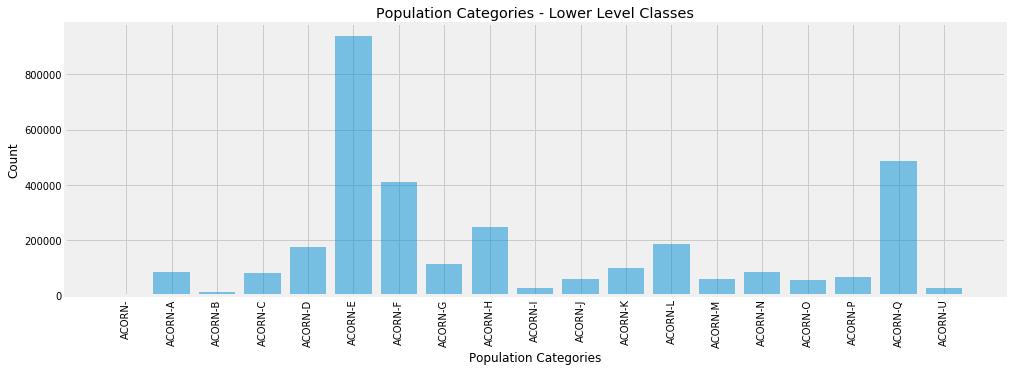

In [24]:
#PLOT THE DEMOGRAPHIC CATEGORIES - PLOT BY COUNT
data = daily_meter_merge.groupby('Acorn').count()['energy'].reset_index()

plt.figure(figsize=[15,5])
plt.bar(data['Acorn'],data['energy'],align='center', alpha=0.5)
plt.xlabel('Population Categories')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Population Categories - Lower Level Classes')
plt.show()

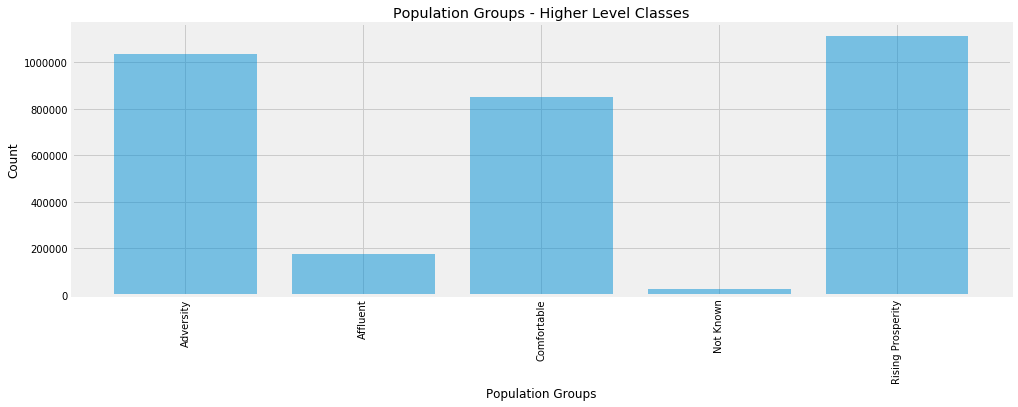

In [25]:
#PLOT THE POPULATION GROUPS - PLOT BY COUNT
data = daily_meter_merge.groupby('Acorn_grouped').count()['energy'].reset_index()

plt.figure(figsize=[15,5])
plt.bar(data['Acorn_grouped'],data['energy'],align='center', alpha=0.5)
plt.xlabel('Population Groups')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Population Groups - Higher Level Classes')
plt.show()

From the above 2 plots what i can understand is that in both the graphs show that the rising prosperity,Comfortable and Adversity are the groups with more energy consumption data. 

#### TARIFF CATEGORIES ANALYSIS
There are 1100 houses with the "Dynamic Tariff(ToU)" Group and the remaning are with the "Standard(Std)" Group.

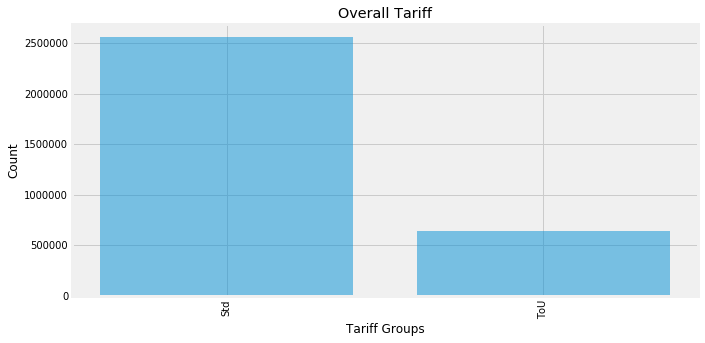

In [26]:
#PLOT THE TARIFF GROUPS - PLOT BY COUNT
data = daily_meter_merge.groupby('stdorToU').count()['energy'].reset_index()

plt.figure(figsize=[10,5])
plt.bar(data['stdorToU'],data['energy'],align='center', alpha=0.5)
plt.xlabel('Tariff Groups')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title('Overall Tariff')
plt.show()

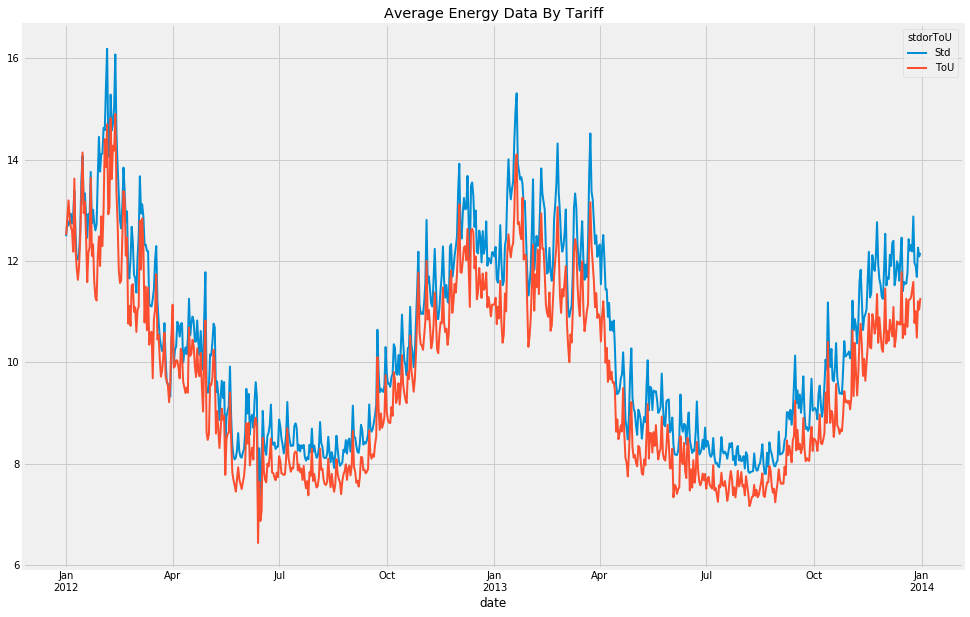

In [27]:
#PLOT THE TARIFF GROUPS - PLOT ACROSS DATE RANGES
fig, ax = plt.subplots(figsize=(15,10))
# use unstack()
daily_meter_merge.groupby(['date','stdorToU']).mean()['energy'].unstack().plot(ax=ax,linewidth=2.0)
plt.title('Average Energy Data By Tariff')
plt.show()

Each household has a different tariff associated and it looks like from the above the chart that the tariff does not seem to have any impact on the average energy. The spread looks normal increasing in winter and slowly decresing for the other seasons. I will be using tariffs for my future improvements of this assignment.

#### DAILY ENERGY CONSUMTION
The first plot is the average energy consumption from Jan 2 2012 untio Dec 31 2013

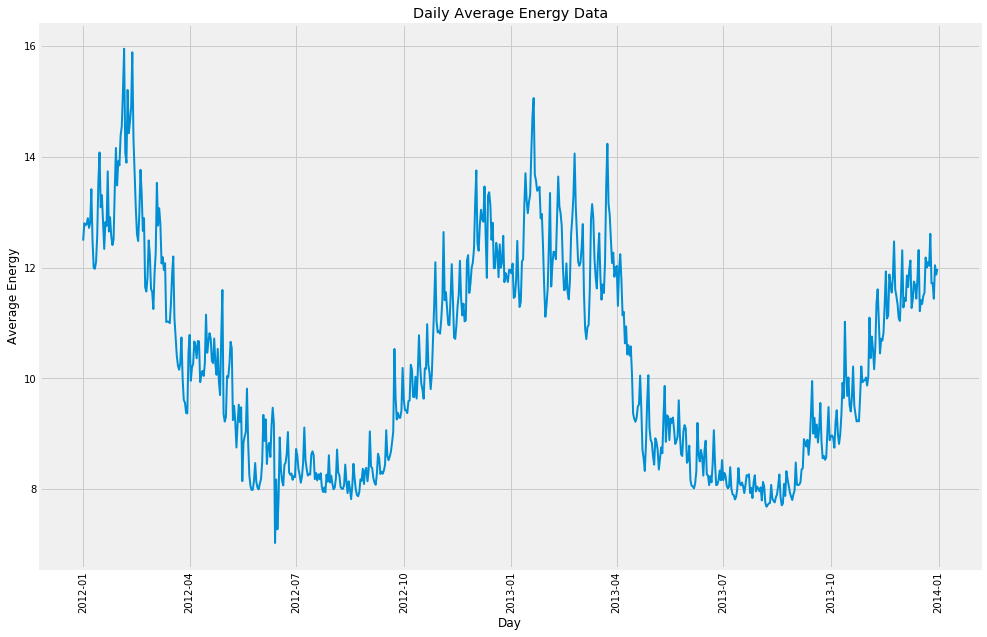

In [28]:
#PLOT THE DAILY DATA PLOT GROUPED BY DAY AND ENERGY MEAN 
df_count=daily_meter_merge.groupby(["date"]).agg({'energy':['mean']}).reset_index()

plt.figure(figsize=[15,10])
plt.plot(df_count['date'],df_count['energy'],linewidth=2.0)
plt.xlabel('Day')
plt.ylabel('Average Energy')
plt.xticks(rotation=90)
plt.title('Daily Average Energy Data')
plt.show()

From the above plot this is what i can see:

  1) The energy consumption has a spike for the winter seasons and see slow decrease from spring to again start rising as fall ends.    
  2) And when looking at winter, all 3 winter look different. The first winter spike is higher when compared to the others so it looks like something different happened on a specific.    
  3) And even though winters show a spike, i can also see some sharp drops in winter, could be a holiday time which causes sthe decrease.
  
So to conclude and understand what is going on with those specific dates, i plotted the below 2 for the specific months of Feb and March alongwith the weather(temperature) data.

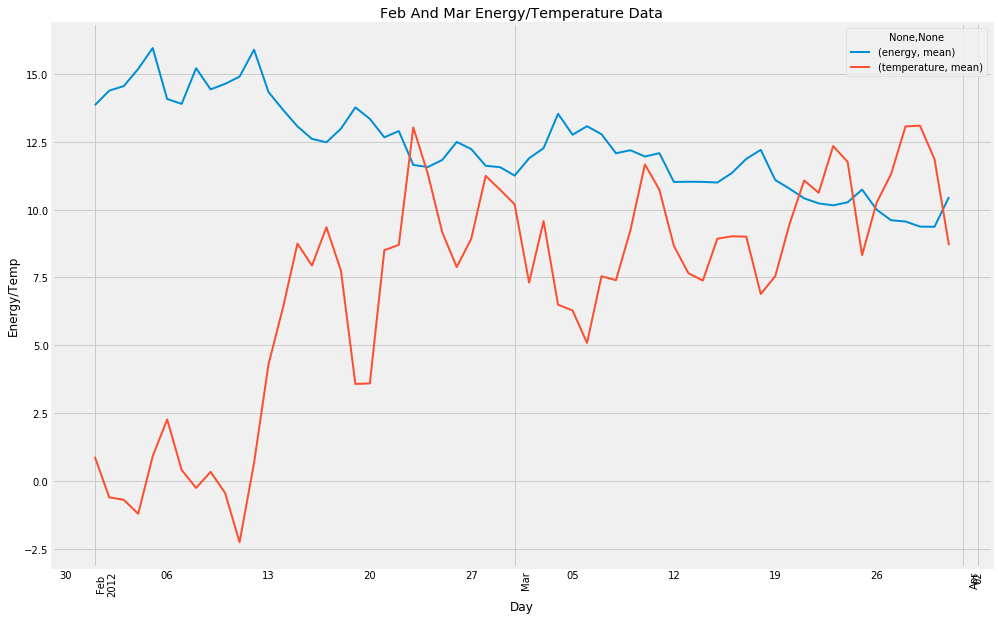

In [29]:
#PLOT THE DAILY DATA FOR THE FIRST WINTER DATA 
df_winter = daily_meter_merge[(daily_meter_merge['date'] >= '2012-02-01') & (daily_meter_merge['date'] <= '2012-03-31')]

df_count=df_winter.groupby(["date"]).agg({'energy':['mean'],'temperature':['mean']}).reset_index()

df_count.plot(x='date', y=['energy', 'temperature'], figsize=(15,10),linewidth=2.0, grid=True)
plt.xlabel('Day')
plt.ylabel('Energy/Temp')
plt.xticks(rotation=90)
plt.title('Feb And Mar Energy/Temperature Data')
plt.show()

The plot does show a relationship between temperature and the energy data, so i conclude that weather does have an impact on this increase. But i was able to see that the specific dates that i am seeing the spike are weekends, so it could be one of those days where everyone is home.

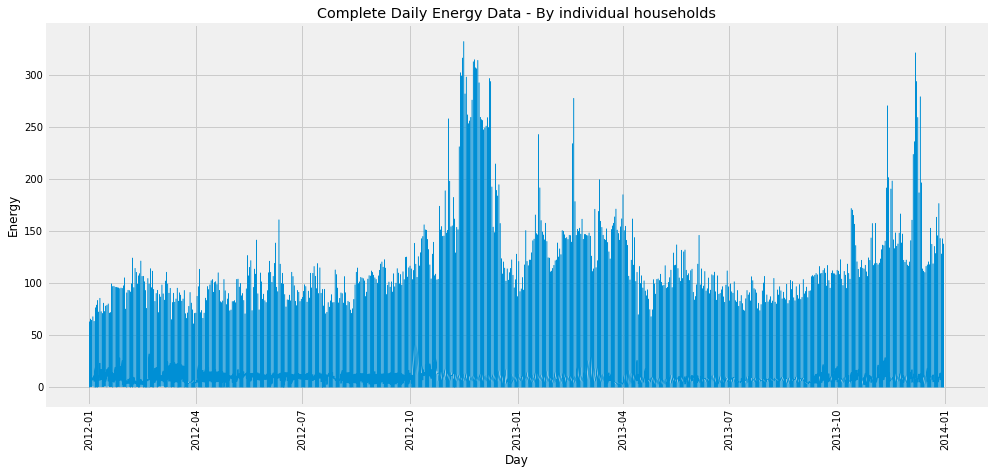

In [30]:
#PLOT THE DAILY DATA PLOT GROUPED BY MONTH AND COUNT
plt.figure(figsize=[15,7])
plt.plot(daily_meter_merge['date'],daily_meter_merge['energy'],linewidth=0.5)
plt.xlabel('Day')
plt.ylabel('Energy')
plt.xticks(rotation=90)
plt.title('Complete Daily Energy Data - By individual households')
plt.show()

The above plot is for indivudual households and it tells me a different story when looking at the overall data:
  
  1) There is no seasonal pattern for this data because the high spikes seem to be spread out for different seasons.
  
  2) There are outliers in this data, but these are genuine outliers so i would look at the weather data to see if the temperature had any impact on those specific spikes.
  
  3) Also the specific spike between the dates 2012-10 to 2013-01 seems to be closer to the year end and chrsitmas time where i believe when we have large families having friends and family home.
  
  4) I see the same spike for 2013-10 to 2014-01 with a similar spike.
  
To understand what happened with those specific months, i will be analyzing the specific month of november.

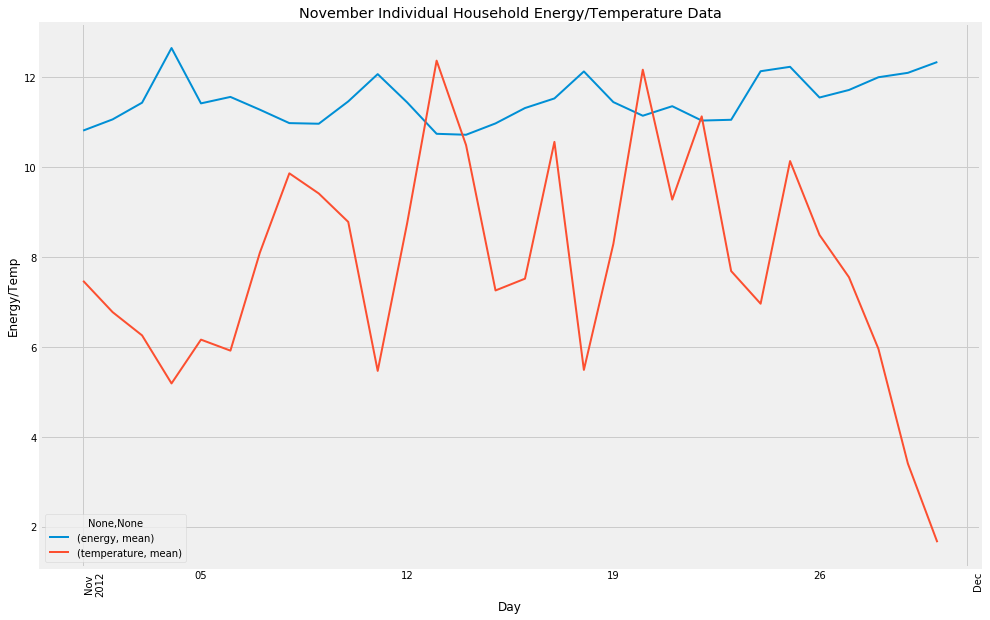

In [31]:
#PLOT THE DAILY DATA FOR THE FIRST WINTER DATA 
df_winter = daily_meter_merge[(daily_meter_merge['date'] >= '2012-11-01') & (daily_meter_merge['date'] <= '2012-11-30')]

df_count=df_winter.groupby(["date"]).agg({'energy':['mean'],'temperature':['mean']}).reset_index()

df_count.plot(x='date', y=['energy', 'temperature'], figsize=(15,10),linewidth=2.0, grid=True)
plt.xlabel('Day')
plt.ylabel('Energy/Temp')
plt.xticks(rotation=90)
plt.title('November Individual Household Energy/Temperature Data')
plt.show()

By just looking at the mean for the month of november, i can say that again this is also specific to the temperature. As the temperature drops to 0 the usage also increases.Moreover at the end of November and Closer to December is the holiday season.Also UK has seasonal events like BonFire Events, St Andrews Day etc.

#### POPULATION VS ENERGY DATA

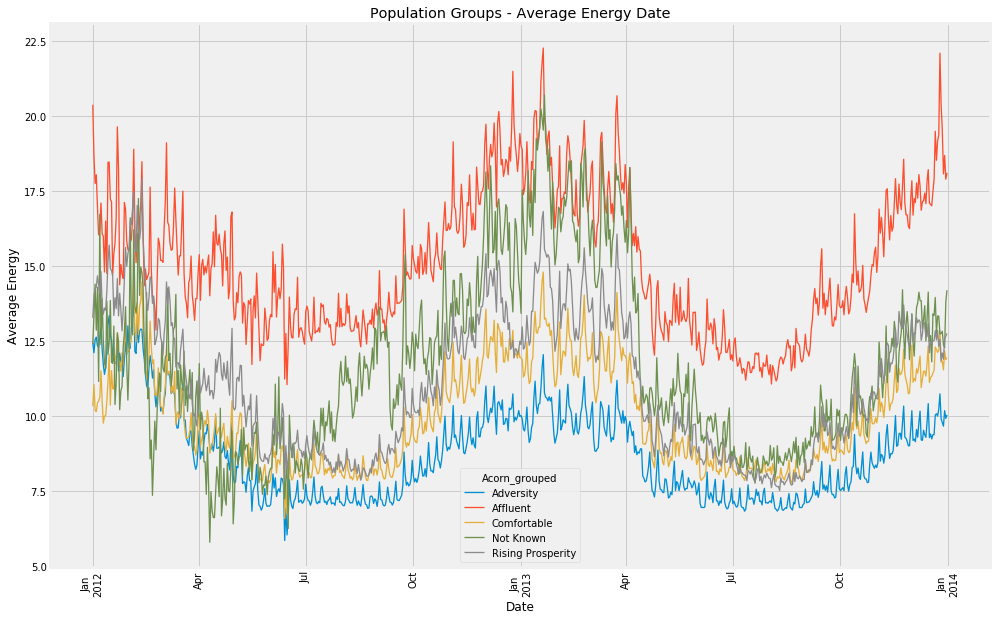

In [32]:
#PLOT THE POPULATION GROUPS - PLOT ACROSS DATE RANGES
fig, ax = plt.subplots(figsize=(15,10))
# use unstack()
daily_meter_merge.groupby(['date','Acorn_grouped']).mean()['energy'].unstack().plot(ax=ax,linewidth=1.3)
plt.xlabel('Date')
plt.ylabel('Average Energy')
plt.xticks(rotation=90)
plt.title('Population Groups - Average Energy Date')
plt.show()

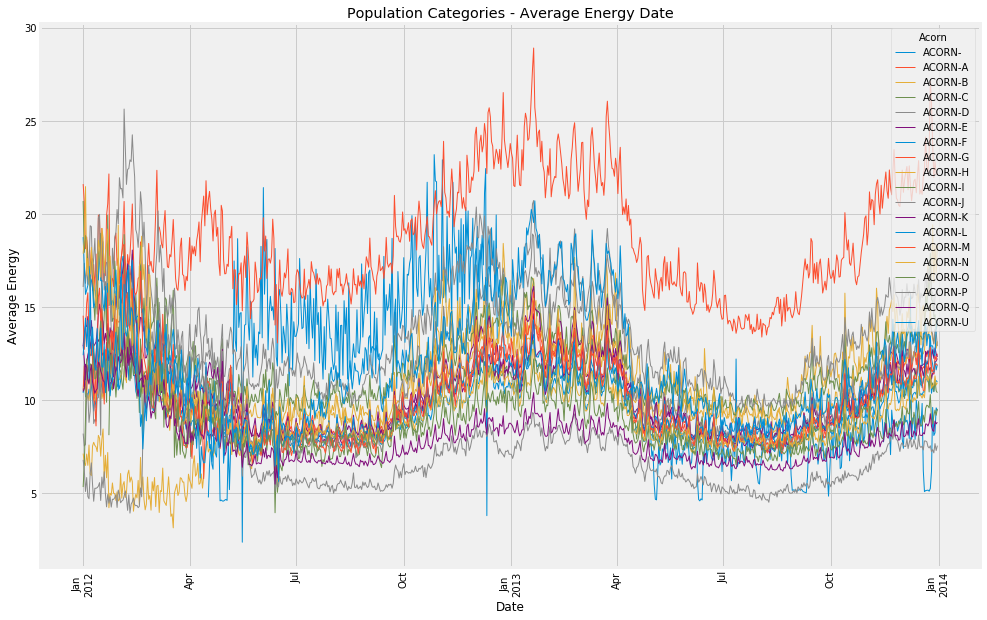

In [33]:
#PLOT THE POPULATION GROUPS - PLOT ACROSS DATE RANGES
fig, ax = plt.subplots(figsize=(15,10))
# use unstack()
daily_meter_merge.groupby(['date','Acorn']).mean()['energy'].unstack().plot(ax=ax,linewidth=1.0)
plt.xlabel('Date')
plt.ylabel('Average Energy')
plt.xticks(rotation=90)
plt.title('Population Categories - Average Energy Date')
plt.show()

A look at the plots tells me that the Affluent and Rising Prosperity Groups seem to be at the upper end and using more energy irrespective of the season, but i cannot conclude this by only looking at the average energy.

#### ADVANCED ANALYSIS
##### CONSUMPTION BY WEEK OF THE YEAR

In [34]:
#EXTRACT THE DAY,MONTH,WEEK OF DAY DATA FROM THE DATETIME 
daily_meter_merge['date'] = pd.to_datetime(daily_meter_merge['date'])
daily_meter_merge["day"]=daily_meter_merge.apply(lambda row: row["date"].strftime("%Y-%m-%d"),axis=1)
daily_meter_merge["month"]=daily_meter_merge.apply(lambda row: int(row["date"].strftime("%m")),axis=1)
daily_meter_merge["year"]=daily_meter_merge.apply(lambda row: int(row["date"].strftime("%Y")),axis=1)
daily_meter_merge["year_day"]=daily_meter_merge.apply(lambda row: int(row["date"].strftime("%j")),axis=1)
daily_meter_merge["weekday"]=daily_meter_merge.apply(lambda row: row["date"].weekday(),axis=1)
daily_meter_merge["hour"]=daily_meter_merge.apply(lambda row: int(row["date"].strftime("%H")),axis=1)

In [35]:
#CREATE THE HEATMAP FOR THE WEEK OF DAY ENERGY CONSUMPTION
week_month_cat=pd.pivot_table(daily_meter_merge, values="energy", index=['month'],columns=['weekday'], aggfunc=np.mean)
week_month_cat.columns=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
week_month_cat.index=["January","February","March","April","May","June","July","August","September","October","November","December"]

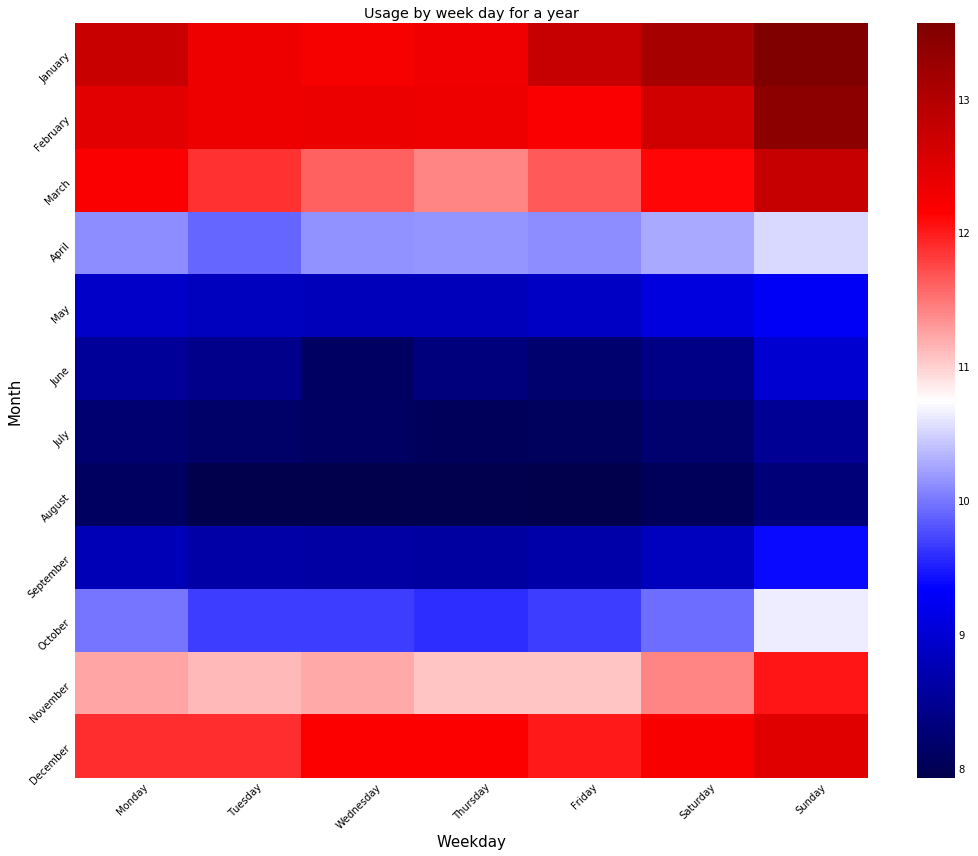

In [36]:
#PLOT THE HEATMAP FOR THE ENERGY DATA SPREAD ACROSS THE WEEK FOR A YEAR
fig,ax=plt.subplots(figsize=(15,12))
sns.heatmap(week_month_cat,cmap='seismic')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.ylabel("Month",fontsize=15)
plt.xlabel("Weekday",fontsize=15)
plt.title('Usage by week day for a year')
fig.tight_layout()
plt.show()

This is another view into how the energy is used by the week days throughout the year, and again I can see the below listed:

1) Weekends have a higher usage when compared to the other days.

2) Winter months of December to March seem to have higher energy usage when comapared to the rest of the year.

3) And the months of June, July and August seem to have very less usage when compared to the rest of the year.

So i can conclude that weather and holidays seem to have some impact on the energy usage. The below plot for weather and temperature also show the same information.

##### WEATHER DATA ANALYSIS

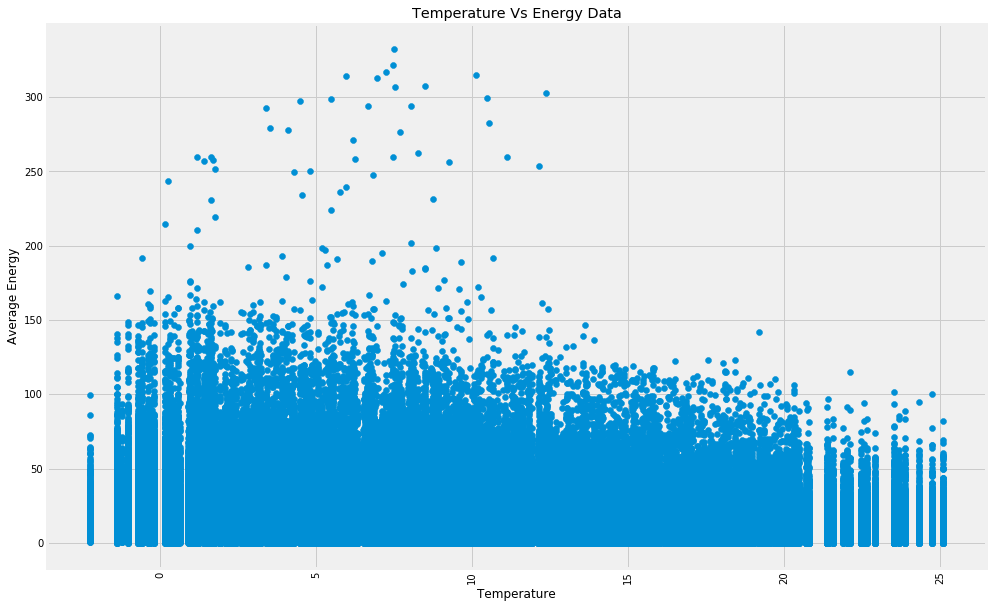

In [37]:
#PLOT THE TEMPERATURE AGAINST THE ENERGY DATA
plt.figure(figsize=[15,10])
plt.scatter(daily_meter_merge['temperature'],daily_meter_merge['energy'])
plt.xlabel('Temperature')
plt.ylabel('Average Energy')
plt.xticks(rotation=90)
plt.title('Temperature Vs Energy Data')
plt.show()

## DATA MODEL

As the overall goal of this analysis is to identify consumers categories of who belong to usage classes of high,moderate and low; and forecast using timeseries for a single household and the global consumption of the 5000 households. This will help utilities and energy companies plan for the future supply and also make sure that they can help the households conserve energy by providing them pricing options and incentives.

The first way we are going to create additional categories is by identifying opportunities to create higher-level categories out of the variables we already have in our data set. I will use an ARIMA model to forecast supply / demand of energy for next 12 months by day.

### Segment Consumers from Continuous Variables - BY ENERGY
In the above i have already created some dataframes to understand how the energy data looks like, so i will create a new columns 5 categories based on the below listed classes:

1) IF ENERGY GREATER THAN 100 KWH THEN "VERY HIGH USAGE"

2) IF ENERGY GREATER THAN 50 KWH AND LESS THAN 100 THEN "HIGH USAGE"

3) IF ENERGY GREATER THAN 25 KWH AND LESS THAN 50 THEN "MODERATE USAGE"

4) IF ENERGY GREATER THAN 10 KWH AND LESS THAN 25 THEN "LOW USAGE"

5) IF ENERGY GREATER THAN 10 KWH THEN "VERY LOW USAGE"

I will be looking at how these categories show the spread of the consumption acorss the various population groups. 

In [38]:
#CREATE CLASSES FOR ENERGY CONSUMPTION
filter_method = lambda x: 'Very High Usage' if x > 100 else 'High Usage' if (x <= 100 and x > 50) else 'Moderate Usage' if (x <= 50 and x > 25) else 'Low Usage' if (x <= 25 and x > 10) else 'Very Low Usage' if x <= 10 else None
daily_meter_merge['Energy Usage'] = daily_meter_merge['energy'].apply(filter_method)
daily_meter_merge['date'] = pd.to_datetime(daily_meter_merge['date'])
daily_meter_merge.head()

date      LCLid  energy stdorToU    Acorn      Acorn_grouped  \
0 2012-01-01  MAC000015   6.327      ToU  ACORN-E  Rising Prosperity   
1 2012-01-01  MAC000016   5.813      Std  ACORN-K          Adversity   
2 2012-01-01  MAC000017   5.635      ToU  ACORN-C           Affluent   
3 2012-01-01  MAC000018   7.875      Std  ACORN-E  Rising Prosperity   
4 2012-01-01  MAC000019   6.594      Std  ACORN-K          Adversity   

       file  visibility  windBearing  temperature       ...        \
0  block_19    12.32375   226.916667    11.092083       ...         
1  block_75    12.32375   226.916667    11.092083       ...         
2   block_5    12.32375   226.916667    11.092083       ...         
3  block_31    12.32375   226.916667    11.092083       ...         
4  block_76    12.32375   226.916667    11.092083       ...         

   apparentTemperature  windSpeed  humidity         day  month  year  \
0            10.297917   5.004167  0.896667  2012-01-01      1  2012   
1            10.297917   5.004167  0.896667  2012-01-01      1  2012   
2            10.297917   5.004167  0.896667  2012-01-01      1  2012   
3            10.297917   5.004167  0.896667  2012-01-01      1  2012   
4            10.297917   5.004167  0.896667  2012-01-01      1  2012   

   year_day  weekday  hour    Energy Usage  
0         1        6     0  Very Low Usage  
1         1        6     0  Very Low Usage  
2         1        6     0  Very Low Usage  
3         1        6     0  Very Low Usage  
4         1        6     0  Very Low Usage  

[5 rows x 22 columns]

In [39]:
#CREATE SEGMENTS FOR WHO USES VERY HIGH/HIGH ENERGY - ANALYZE WHICH POPULATION GROUPS USES MORE
high_energy_usage = daily_meter_merge
high_energy_usage = high_energy_usage[(high_energy_usage['Energy Usage'] == 'High Usage') | (high_energy_usage['Energy Usage'] == 'Very High Usage')]
high_energy_usage.drop(['stdorToU','visibility','windBearing','temperature','dewPoint','pressure','apparentTemperature','windSpeed','humidity'],axis=1,inplace=True)
high_energy_usage.head()

date      LCLid  energy    Acorn      Acorn_grouped       file  \
19  2012-01-01  MAC000034  51.533  ACORN-E  Rising Prosperity   block_36   
90  2012-01-01  MAC000105  52.362  ACORN-D  Rising Prosperity    block_9   
118 2012-01-01  MAC000134  63.168  ACORN-L          Adversity   block_83   
272 2012-01-01  MAC004469  60.159  ACORN-Q          Adversity  block_104   
501 2012-01-02  MAC000105  65.824  ACORN-D  Rising Prosperity    block_9   

            day  month  year  year_day  weekday  hour Energy Usage  
19   2012-01-01      1  2012         1        6     0   High Usage  
90   2012-01-01      1  2012         1        6     0   High Usage  
118  2012-01-01      1  2012         1        6     0   High Usage  
272  2012-01-01      1  2012         1        6     0   High Usage  
501  2012-01-02      1  2012         2        0     0   High Usage

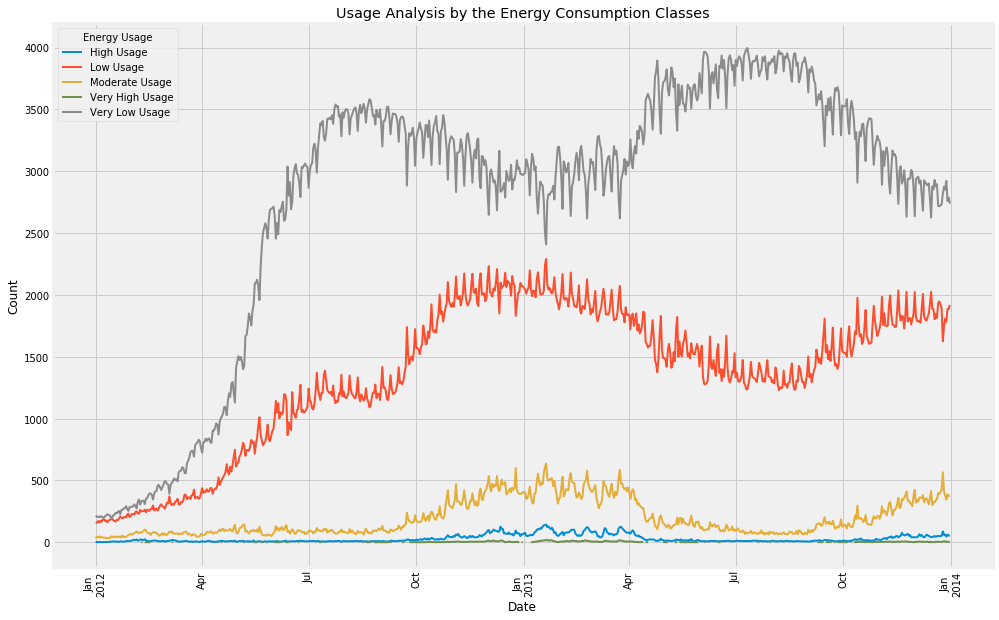

In [40]:
#ENERGY USAGE BY DATE
fig, ax = plt.subplots(figsize=(15,10))
# use unstack()
daily_meter_merge.groupby(['date','Energy Usage']).count()['energy'].unstack().plot(ax=ax,linewidth=2.0)
plt.title('Usage Analysis by the Energy Consumption Classes')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

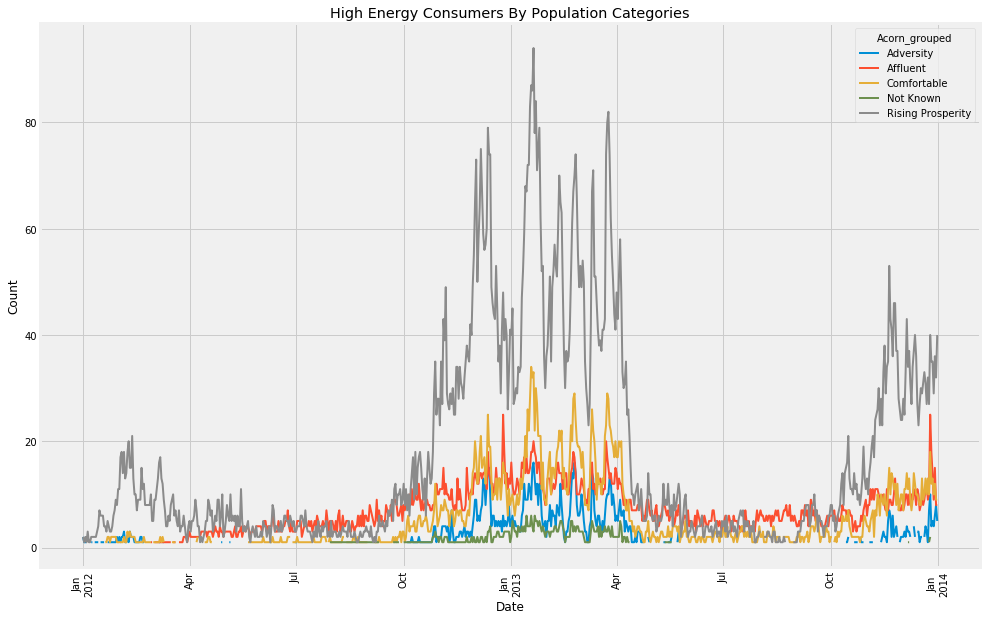

In [41]:
#ENERGY USAGE AND POPULATION
fig, ax = plt.subplots(figsize=(15,10))
# use unstack()
high_energy_usage.groupby(['date','Acorn_grouped']).count()['Energy Usage'].unstack().plot(ax=ax,linewidth=2.0)
plt.title('High Energy Consumers By Population Categories')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

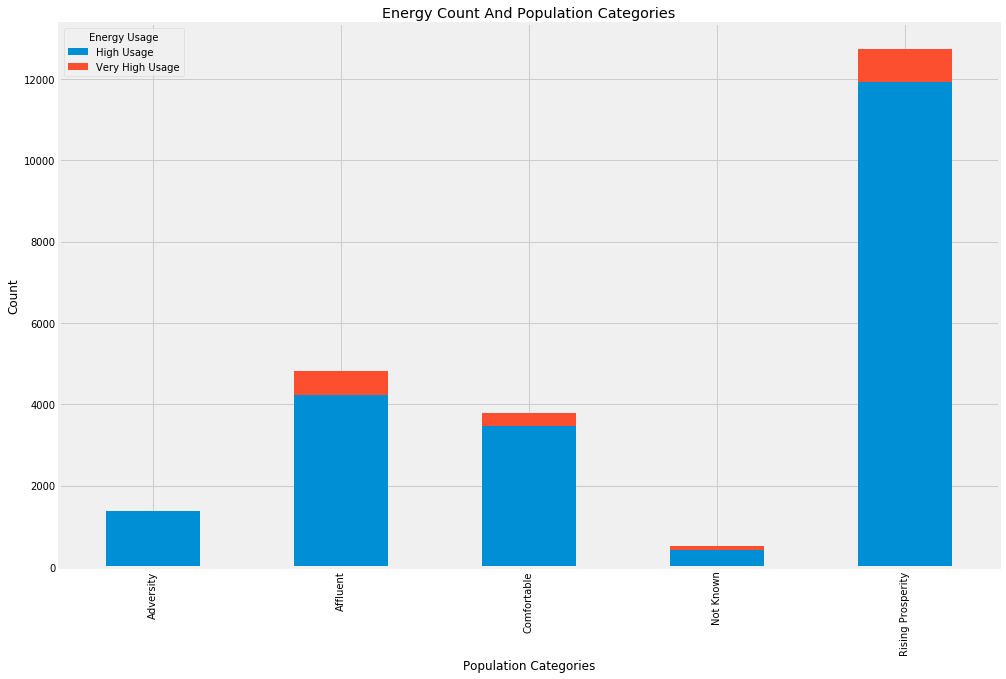

In [42]:
#PLOT THE POPULATION GROUPS - PLOT BY COUNT
fig, ax = plt.subplots(figsize=(15,10))
# use unstack()
high_energy_usage.groupby(['Acorn_grouped','Energy Usage']).size().unstack().plot.bar(ax=ax,stacked=True)
plt.title('Energy Count And Population Categories')
plt.xlabel('Population Categories')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [43]:
#FIND THE NUMBER OF HOMES IN THIS HIGH ENERGY CATEGORY
high_groups = high_energy_usage.groupby(['LCLid','Energy Usage']).size().unstack()
high_groups.count()

Energy Usage
High Usage         555
Very High Usage     70
dtype: int64

It was important for me to understand which population groups has the higher numbers and also how the usage classes spread looked like so this is my understanding from the above 3 plots:

  1) From the usage classes it is comparatively lesser number of homes but when we look at the count of the households it is actually 625 households in total, which is approximately 11% of the population. 
    
  2) But when i look at only the "Very High Usage" class which is only at 1%, does not seem like a large number but when looking this category a little closer i found that this group had usage greater than 100 KWH.
    
  3) And also looking at the population categories, looks different because its the "Rising Properity" Group seems to be at the higher end which the most number of high usage consumers.

So for my analysis i will be using the households from this is specific group. Another plot below to see how the energy conumption mean looks like.

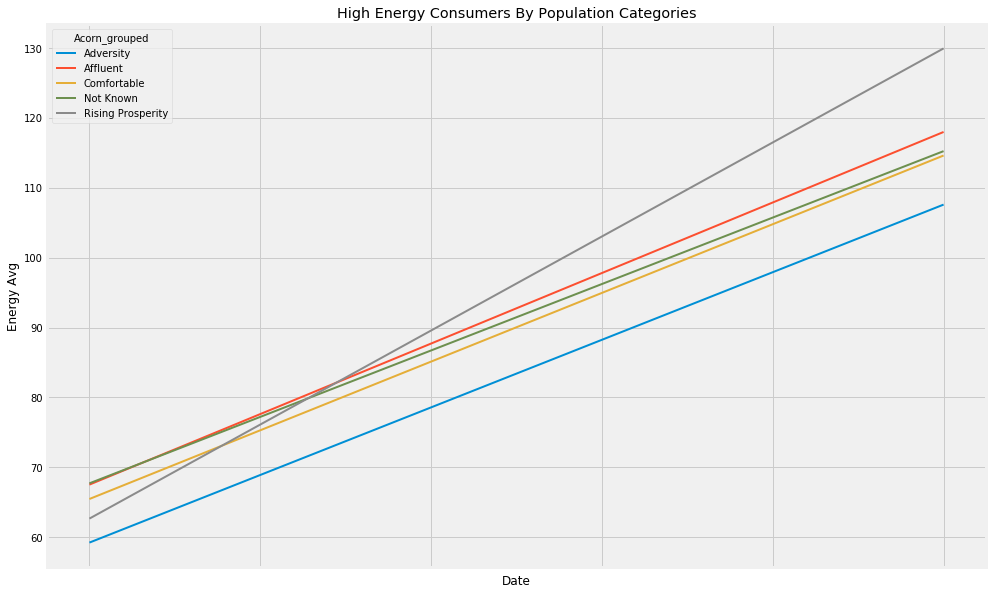

In [44]:
#ENERGY USAGE AND DEMOGRAPHICS
fig, ax = plt.subplots(figsize=(15,10))
# use unstack()
high_energy_usage.groupby(['Energy Usage','Acorn_grouped']).mean()['energy'].unstack().plot(ax=ax,linewidth=2.0)
plt.title('High Energy Consumers By Population Categories')
plt.xlabel('Date')
plt.ylabel('Energy Avg')
plt.xticks(rotation=90)
plt.show()

The below plots are for my understanding to see the usage all classes across the population categories.

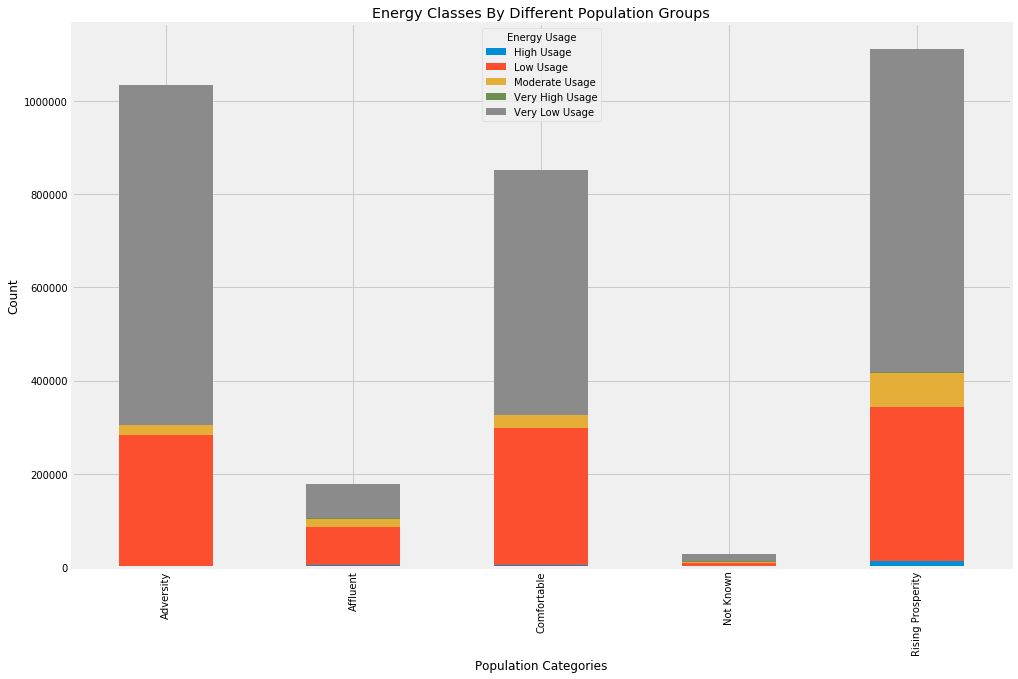

In [45]:
#PLOT THE DEMOGRAPHIC GROUPS - PLOT BY COUNT
fig, ax = plt.subplots(figsize=(15,10))
# use unstack()
daily_meter_merge.groupby(['Acorn_grouped','Energy Usage']).size().unstack().plot.bar(ax=ax,stacked=True)
plt.title('Energy Classes By Different Population Groups')
plt.xlabel('Population Categories')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

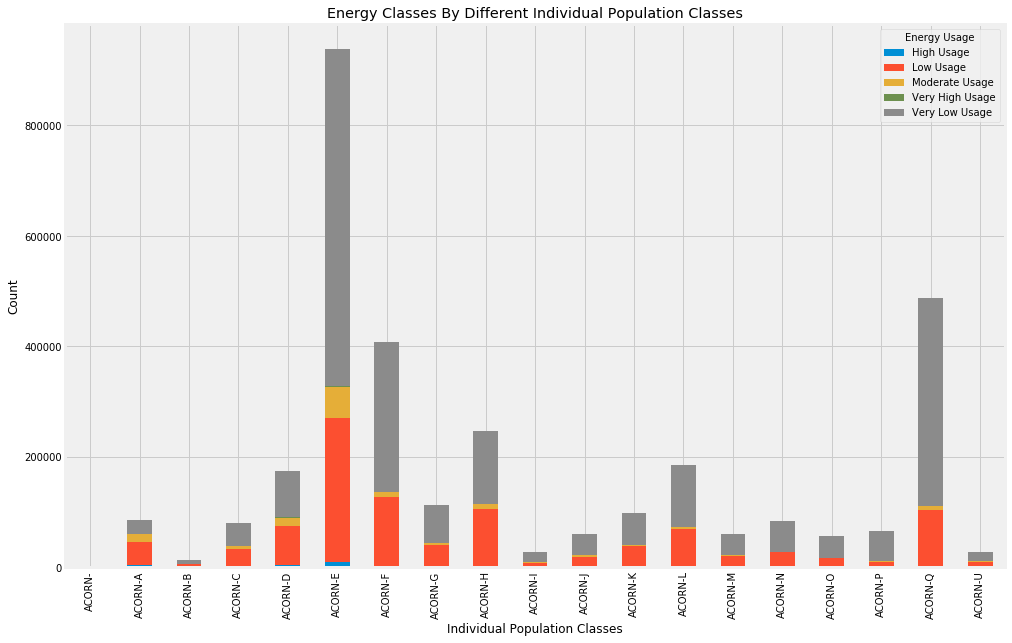

In [46]:
#PLOT THE DEMOGRAPHIC GROUPS - PLOT BY COUNT
fig, ax = plt.subplots(figsize=(15,10))
# use unstack()
daily_meter_merge.groupby(['Acorn','Energy Usage']).size().unstack().plot.bar(ax=ax,stacked=True)
plt.title('Energy Classes By Different Individual Population Classes')
plt.xlabel('Individual Population Classes')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

###  TIMESERIES FORECAST - SINGLE HOUSEHOLD
Forecasting is a way to predict the future based on available data and understand what might and might not impact the prediction.

Timeseries analysis is a way to understand  what happened in the past to make better , profitable decisions in the Future. And the timeseries data is indexed by time and is sequential. Some of the most important concepts of timeseries which i will be using in my analysis are: Trend, Seasonality, Cyclic and Remainder/Residual/White Noise.

1) Trend : This is to understand if the data or the timeseries is moving in a specific direction: increasing or decreasing.

2) Seasonality : This is to understand if the data has any seasonality or if it is based on the calendar like do we see anything on weekly, monthly, quarterly, seasons. This specific feature is bound by a frequency of the calendar and does not change.

3) Cyclic: This is similar to seasonality where there is a pattern we may based on a business cycle like an economic condition or a reset pattern that happens only every few years. This is not bound by a frequency like the seaonality feature and this is usefull only when we look at more number of years. So i dont think there will be any cyclic pattern for this energy consumption data.

4) Remainder/Residual - As the name suggests this is the remaining data that can be seen after the key features like Trend and Seasonality have extracted what is there in the dataset.

#####  EXTRACT SINGLE HOUSEHOLD TIMESERIES
The first few steps will show the processing of data , as mentioned earlier this analysis is for a single household from the "Rising Prosperity" Group and has very high usage. The household should also have data for all the days,  i want to make sure i see some clear patterns for my analysis. But in a real scenario this might not be the case and i will have to run my analysis irrespective of how many dates are present.

In [47]:
#FIND WHICH HOUSES OR HOMES ARE THERE IN THE VERY HIGH USAGE CATEGORY
high_groups = high_energy_usage.groupby(['LCLid','Energy Usage']).size().unstack()
homes_very_high = high_groups.groupby(['LCLid']).count()['Very High Usage'].reset_index()
homes_very_high = homes_very_high.loc[homes_very_high.ne(0).all(axis=1)]
homes_very_high.count()

LCLid              70
Very High Usage    70
dtype: int64

In [48]:
#EXTRACT THE TIMESERIES FROM THE 70 IDENTIFIED HOMES IN VERY HIGH USAGE AND THE RISING PROSPERITY GROUP
home_match_high_usage = pd.merge(daily_meter_merge,high_groups,on='LCLid')
home_match_high_usage = home_match_high_usage[home_match_high_usage['Acorn'] == 'ACORN-D']
home_match_high_usage = home_match_high_usage[['date','LCLid','energy','Energy Usage']]
home_match_high_usage.head()

date      LCLid  energy    Energy Usage
5117 2012-01-01  MAC000079  12.408       Low Usage
5118 2012-01-02  MAC000079   9.392  Very Low Usage
5119 2012-01-03  MAC000079  13.021       Low Usage
5120 2012-01-04  MAC000079  11.694       Low Usage
5121 2012-01-05  MAC000079  10.363       Low Usage

In [49]:
#FIND THOSE HOMES WHICH HAVE COMPLETE DATA FOR ALL DATES FOR THE YRS 2012 AND 2013
home_match_high_usage['Count'] = home_match_high_usage.groupby(['LCLid'])['energy'].transform('count')
filter_by = home_match_high_usage[home_match_high_usage['Count'] == 731]
filter_by.groupby('LCLid').size()

LCLid
MAC000085    731
MAC000105    731
MAC000194    731
MAC004527    731
dtype: int64

In [50]:
#FORECAST FOR ONE HIGH USAGE HOME - CHOOSE A HOME WITH COMPLETE SERIES FOR 2 YRS
high_energy_usage_home = daily_meter_merge[daily_meter_merge['LCLid'] == 'MAC000105']
high_energy_usage_home.head()

date      LCLid  energy stdorToU    Acorn      Acorn_grouped  \
90   2012-01-01  MAC000105  52.362      Std  ACORN-D  Rising Prosperity   
501  2012-01-02  MAC000105  65.824      Std  ACORN-D  Rising Prosperity   
912  2012-01-03  MAC000105  64.652      Std  ACORN-D  Rising Prosperity   
1330 2012-01-04  MAC000105  68.020      Std  ACORN-D  Rising Prosperity   
1750 2012-01-05  MAC000105  63.598      Std  ACORN-D  Rising Prosperity   

         file  visibility  windBearing  temperature      ...       \
90    block_9   12.323750   226.916667    11.092083      ...        
501   block_9   13.227500   235.583333     5.942500      ...        
912   block_9   10.795833   234.125000     8.759583      ...        
1330  block_9   12.610833   252.708333     7.061667      ...        
1750  block_9   12.920000   285.750000     9.576667      ...        

      apparentTemperature  windSpeed  humidity         day  month  year  \
90              10.297917   5.004167  0.896667  2012-01-01      1  2012   
501              2.611250   4.905000  0.805833  2012-01-02      1  2012   
912              5.929583   9.079583  0.815417  2012-01-03      1  2012   
1330             2.841667   8.175417  0.777917  2012-01-04      1  2012   
1750             7.160417   9.977917  0.696667  2012-01-05      1  2012   

      year_day  weekday  hour  Energy Usage  
90           1        6     0    High Usage  
501          2        0     0    High Usage  
912          3        1     0    High Usage  
1330         4        2     0    High Usage  
1750         5        3     0    High Usage  

[5 rows x 22 columns]

Timeseries data has to be indexed by the date column.

In [51]:
#PROCESS FOR TIMESERIES - FOR ONE HIGH USAGE CONSUMER ONLY
#INDEX FOR TIMESERIES BY THE DATE COLUMNS
high_usage = high_energy_usage_home[['date','energy']]
high_usage['date'] = high_usage['date'].astype('datetime64[D]')
high_usage = high_usage.set_index('date')
high_usage.head()

energy
date              
2012-01-01  52.362
2012-01-02  65.824
2012-01-03  64.652
2012-01-04  68.020
2012-01-05  63.598

Text(0, 0.5, 'Energy Usage')

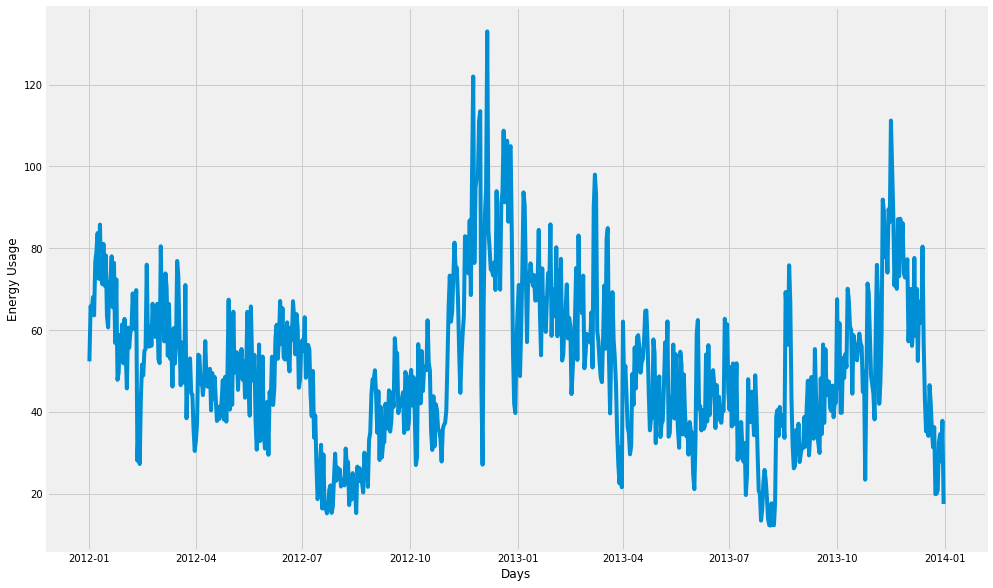

In [52]:
#PLOT THE ENERGY DATA FOR THE SINGLE HOME
plt.figure(figsize=(15, 10))
plt.plot(high_usage)
plt.xlabel('Days')
plt.ylabel('Energy Usage')

From my understanding of Trend and Seasonality, i can see that both exist in this timeseries. 

1) Comparing the first years daily to the second years daily, it looks like there is an increase which shows an upward trend from the previous year.

2) For Seasonality i can see winter showing similar patterns of increase and decrease, where every winter from November to March theres an increase in the consumption.

3) Also to compare the months of July to October for both periods, for 2013 i can see there is a spot where there is an increase. 

#####  CHECK FOR STATIONARY /NON STATIONARY

Checking if the timeseries is stationary or non stationary is one of the important concepts to make sure we have a close to accurate forecast. Stationary is the process where the mean, variance and covarince do not change over time and remain constant. Especially when the variance is a constant then the data is said to be homoscedastic. There are multiple ways to check this and for my analysis i will be using the rolling mean and variance plots and the Dickey Fuller statistic test.

1) The first is to get the rolling mean and standard deviation to check for any change in the trend. 

2) The second one is to use the Dickey Fuller Statistic to check if the data is stationary or not.

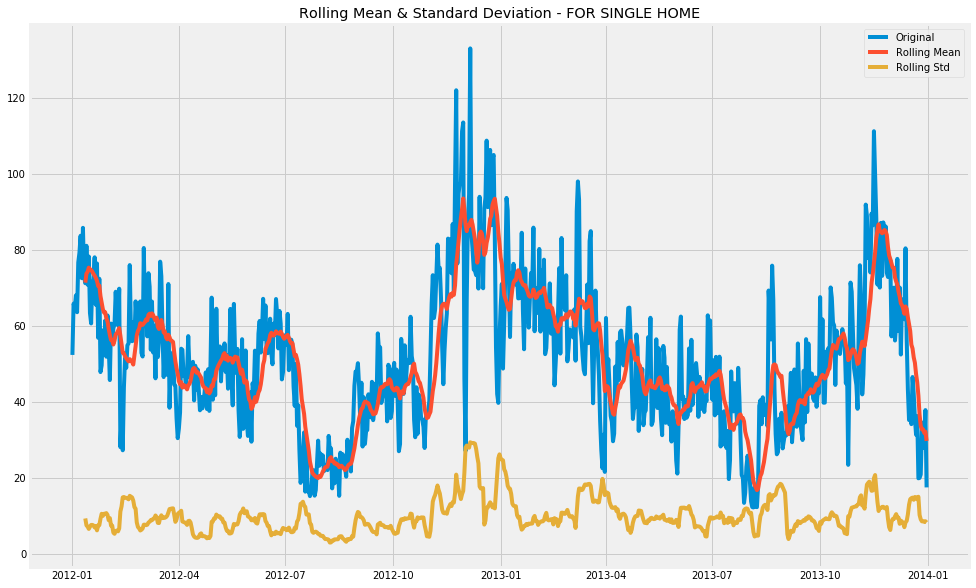

In [53]:
#CHECK IF THE DATA IS STATIONARY - PLOT BY ROLLING STATISTICS
rollingmean = high_usage.rolling(window=12).mean()
rollingstd = high_usage.rolling(window=12).std()

#Plot rolling statistics:
plt.figure(figsize=[15,10])
observed = plt.plot(high_usage, label='Original')
rolmean = plt.plot(rollingmean, label='Rolling Mean')
rolstd = plt.plot(rollingstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation - FOR SINGLE HOME')
plt.show(block=False)

In [54]:
#DICKER FULLER TEST - #VERIFY THE TS IS NON_STATIONARY
rp = high_usage['energy']
print("Results for the Dicker Fuller Test:")
adfullertest = adfuller(rp,autolag='AIC')
dfullerout = pd.Series(adfullertest[0:4],index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in adfullertest[4].items():
    dfullerout['Critical Value (%s)'%key] = value
print(dfullerout)

Results for the Dicker Fuller Test:
Test Statistic                  -2.980855
p-value                          0.036721
#lags Used                      13.000000
Number of Observations Used    717.000000
Critical Value (1%)             -3.439503
Critical Value (5%)             -2.865579
Critical Value (10%)            -2.568921
dtype: float64


Looking at the first plot it looks like the mean is moving along with the original values and also looking at the Dickey Fuller Test, the test statistic is greater than the critical values which implies that the time series is non stationary.

#####  SEASONALITY DECOMPOSITION

Next is to break the timeseries into Trend, Seasonality and Residuals using the Seasonal Decomposition method. For this there are methods that can applied like "additive" and "multiplicative". 

Additive is used when the seasonal component is more constant and does not fluctuate over time.

Multiplicative is used when we do have a seasonal component but it is presented with a lot of variations over time.

For my analysis and my inference i think additive method would be sufficient as i see a seasonal component with very little variations.

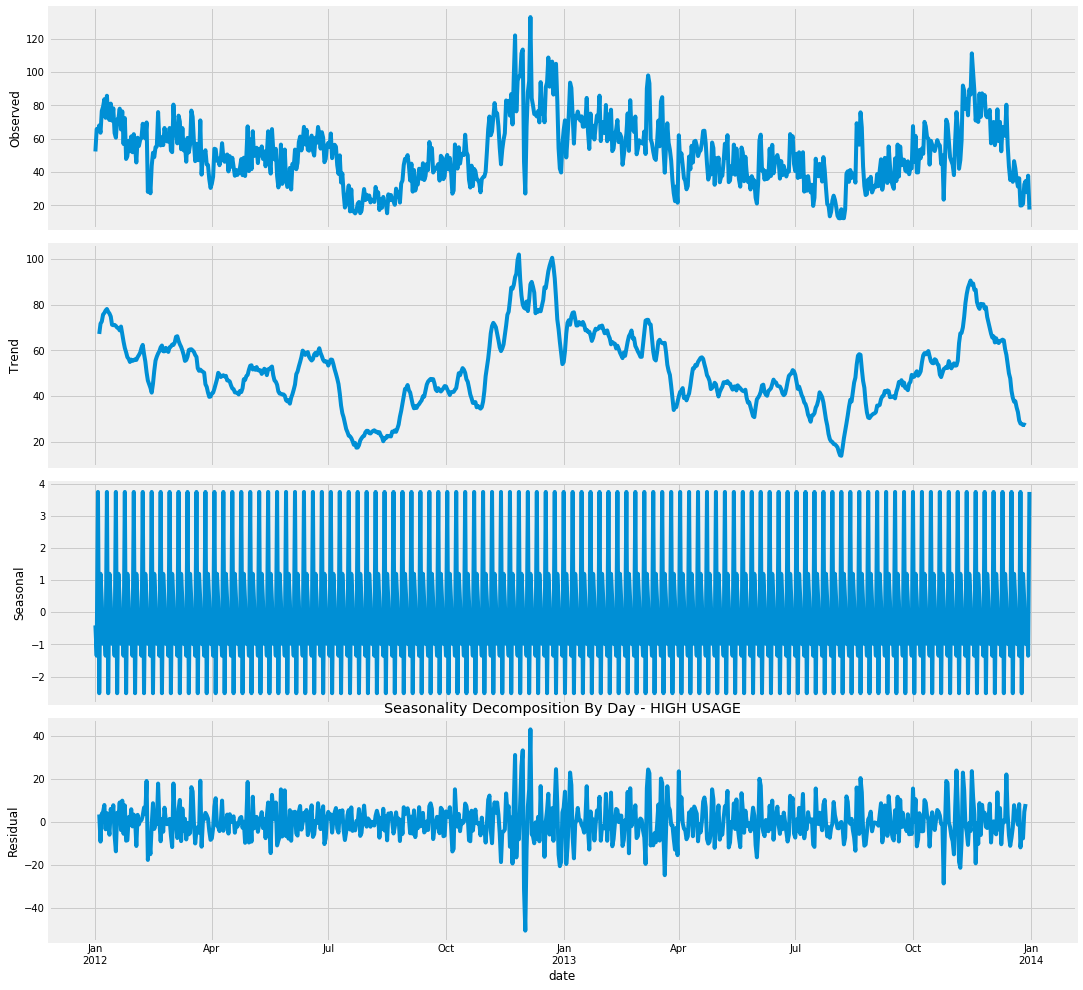

In [55]:
#SEASONALITY DECOMPOSITION FOR SINGLE HIGH USAGE CONSUMER
rcParams['figure.figsize'] = 18, 12
seasonalplot = seasonal_decompose(high_usage,model='additive')
fig = seasonalplot.plot()
fig.set_figwidth(15)
fig.set_figheight(14)
plt.title('Seasonality Decomposition By Day - HIGH USAGE')
plt.show()

Some of the observations from this analysis:-

1) As this is a daily dataset, the trend does seem to show an upward increase when compared to the previous.

2) The seasonal data shows a consistant daily pattern which no fluctuations.

3) And after extracting the trend and the seasonality data i do not see any patterns in the remainder or the residual data which looks more like white noise to me except the one spike in November of 2012 about which we have already discussed in the earlier sections.    

##### ARIMA MODEL

ARIMA model is one of the most common models used for timeseries forecasts and focusses on extracting the data using autocorrelations in the data.The complete abbrievation for ARIMA stands for AutoRegressive Integrated Moving Average and the model depends on 3 key parameters which are major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

The AR or p is parameter for the AutoRegression part of the model which depends on the past values of the data to extract trends and predict the future values.

The I or d is the parameter associated with the integrated part of the model and is one of the ways to extract the trends by applying the differencing part where you subtract the time series with the lagged part of the time series. Moreover Differencing on the data is also a way to make the data stationary with the mean.

The MA or q is the parameter associated with the moving average part of the model where this extracts from the past error values for the future error. 

These same values are present as P,D and Q if the model is a Seasonal ARIMA and i will be using SARIMA for my modeling.

Differencing is a way to make non stationary data to stationary for the mean and getting the log transform is to make sure the variance is stationary. And as the 'd' is to extract the trend part of the series, we can apply some differencing methods to dot this. For my analysis i am using first order differencing which is the difference between the current observations with the previous observations. Usually first order differencing is sufficient to make the data stationary.

One of the best ways to make a series stationary on variance is through transforming the original series through log transform. 
The below plot shows how the series looks after applying differencing and the log transform.

Text(0, 0.5, 'Differenced Log (Energy Usage)')

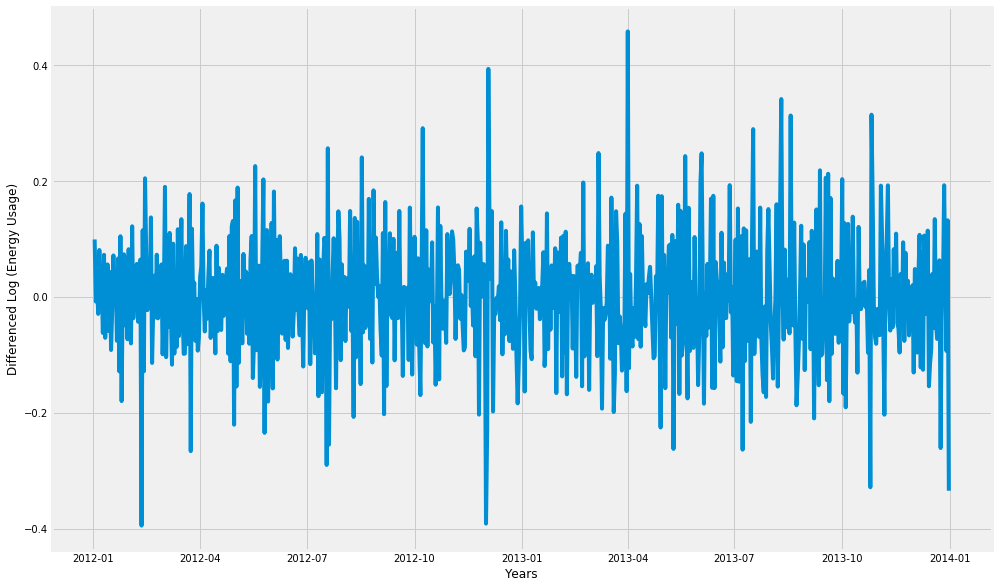

In [56]:
#DIFFERENCE LOG TRANSFORM DATA TO MAKE DATA STATIONARY ON BOTH MEAN AND VARIANCE
plt.figure(figsize=(15, 10))
plt.plot(np.log10(high_usage).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Energy Usage)')

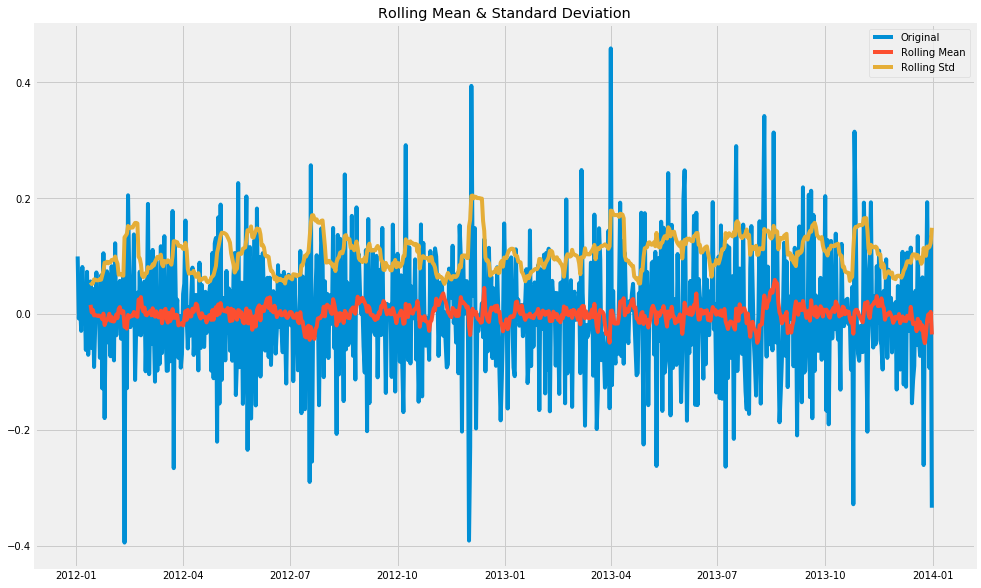

In [57]:
#CHECK IF THE DATA IS STATIONARY - PLOT BY ROLLING STATISTICS
high_usage_diff = np.log10(high_usage).diff(periods=1)
rollingmean = high_usage_diff.rolling(window=12).mean()
rollingstd = high_usage_diff.rolling(window=12).std()

#Plot rolling statistics:
plt.figure(figsize=[15,10])
orig = plt.plot(high_usage_diff, label='Original')
mean = plt.plot(rollingmean, label='Rolling Mean')
std = plt.plot(rollingstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

I am not able to completely understand the original observation pattern but looking at the above i can say the mean and std look constant over time which means the time series is stationary.

#####  PLOT ACF AND PACF
Auto Correlation and Partial Auto Correlation is the check the relationship within the series and this is done by checking the correlation between the series and its lagged timeseries values. So auto correlation is when it checks the correlation is positive, negative or no change between the original and lagged timeseries. A partial autocorrelation does the same thing but it removes the interfering or the in between correlations to avoid a chain reaction.

The reason for using ACF and PACF plots is to understand in which direction the model is designed, like whether it is AR(AutoRegression) or MA(Moving Average) or both.

For my understanding i have used ACF is to find if it is a Moving Average and if it is PACF is it a Auto Regressor. And the below table helps with the identification:

        MA     AR     ARMA
        
ACF       Cuts after q  ---       Tails off  ---          Tails off

PACF      Tails off     ---       Cuts after q  ---       Tails off


In [58]:
#LOG TRANSFORM AND DIFFERENCING - TO MAKE MEAN AND VARIANCE CONSTANT
high_usage_log_diff = np.log10(high_usage).diff(periods=1)
high_usage_log_diff.dropna(inplace=True)

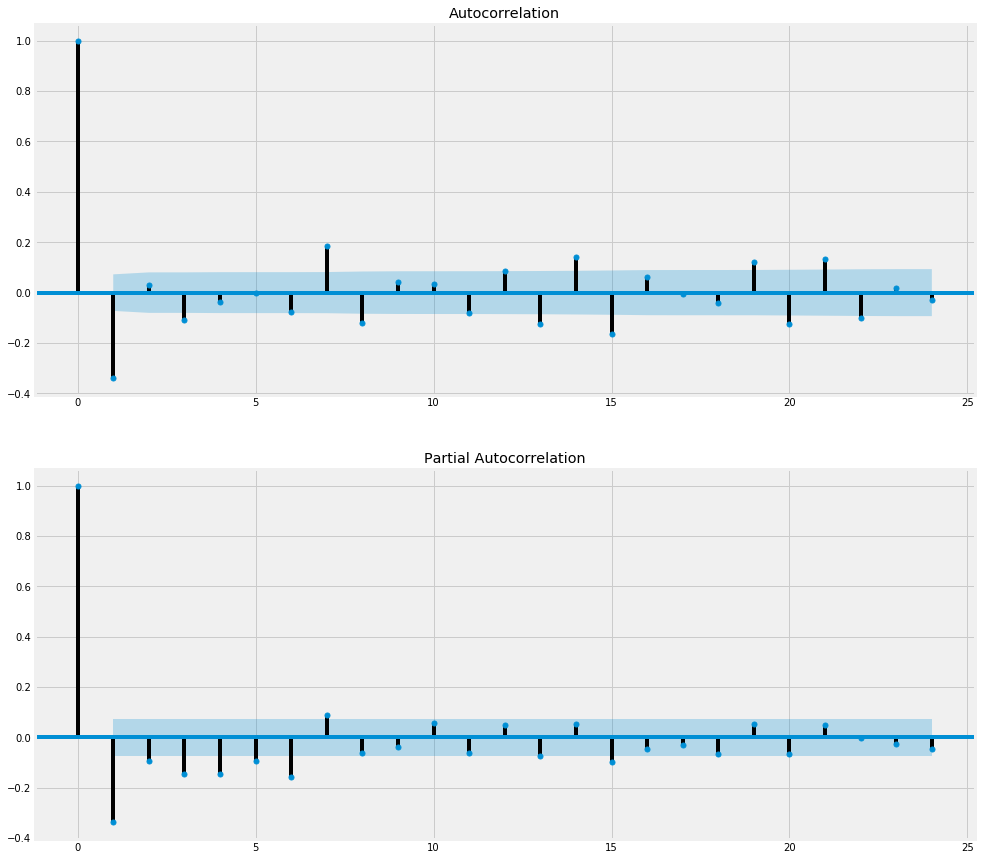

In [59]:
#Plot ACF and PACF to identify potential AR and MA model
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(high_usage_log_diff, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(high_usage_log_diff, lags=24, ax=ax2) 

From my understanding i think that both these have AR and MA, the reason i concluded it is an ARMA is :

1) The PACF plot shows me that the trend tails off slowly towards 0 which is an autogressor.

2) The ACF does not show any seasonal patterns to me, but i do think there is a MA available.

Based on this i know that i will have values for p,d and q, but i will proceed to find the best fit using grid search.

#####  FIND THE BEST FIT FOR ARIMA

For my timeseries forecast i will be using a Seasonal ARIMA model instead of a simple ARIMA. If there is any Seasonality associated with my dataset than i should be using SARIMA, and i believe that there are seasonal extractions which we have already seen.

To find the best parameters for the model i will be using Grid Search, to iteratively find the bext model parametes for the timeseries. And the best parametes are decided based on the AIC(Akaike Information Criterion) which should be minimal, so from the grid search the values with the minimal will be considered as the optimized values.

AIC is a way to find the balance between goodness of fit and the number of parameters chosen, this is how we use when we apply a Linear Regression. The timeseries data is also similar to regression, just that it is auto, on itself.

In [60]:
#LOG TRANSFORM 
high_usage_log = np.log10(high_usage)
high_usage_log.dropna(inplace=True)

In [61]:
#DEFINE P,D and Q VALUES FOR THE ARIMA MODEL
p = d = q = range(0,2)

#GENERATE ALL COMBINATIONS OF P,D AND Q
pdq = list(itertools.product(p,d,q))

#GENERATE ALL COMBINATIONS FOR SEASONAL P,D AND Q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
#FOR TIMESERIES ANALYSIS - FOR A SINGLE HOUSEHOLD
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(high_usage,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

           
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print("Best Seasonal{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

In [62]:
#FIT THE MODEL FOR A SINGLE HIGH USAGE HOUSEHOLD -USING THE BEST PARAMETERS
param_order = (1, 1, 1)
param_seasonal_order = (0, 1, 1, 12)
mod_h = sm.tsa.statespace.SARIMAX(high_usage,
                                order=param_order,
                                seasonal_order=param_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod_h.fit()
print("Blog Seasonal{}x{}12 model - AIC:{}".format(param_order, param_seasonal_order, results.aic))

Blog Seasonal(1, 1, 1)x(0, 1, 1, 12)12 model - AIC:5432.053536995994


In [63]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             energy   No. Observations:                  731
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2712.027
Date:                            Mon, 10 Dec 2018   AIC                           5432.054
Time:                                    19:03:39   BIC                           5450.281
Sample:                                01-01-2012   HQIC                          5439.098
                                     - 12-31-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3841      0.042      9.200      0.000       0.302       0.466
ma.L1         -0.8174      0.029   

#####  PREDICT AND FORECAST

In [64]:
#GET THE PREDICTIONS FOR THE YEAR 2013
pred = results.get_prediction(start= 366,end=730, dynamic=False)
pred_ci = pred.conf_int()

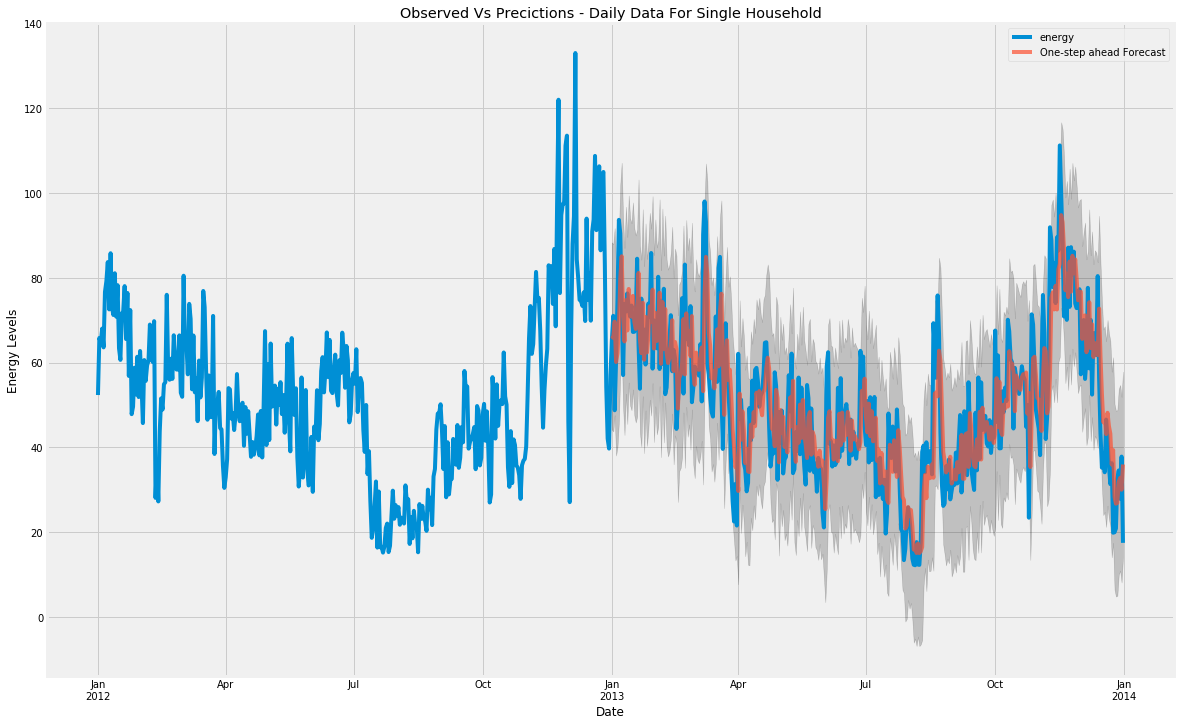

In [65]:
#PLOT THE OBSERVED AND THE PREDICTED VALYES
ax = high_usage['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Energy Levels')
plt.legend()
plt.title('Observed Vs Precictions - Daily Data For Single Household')
plt.show()

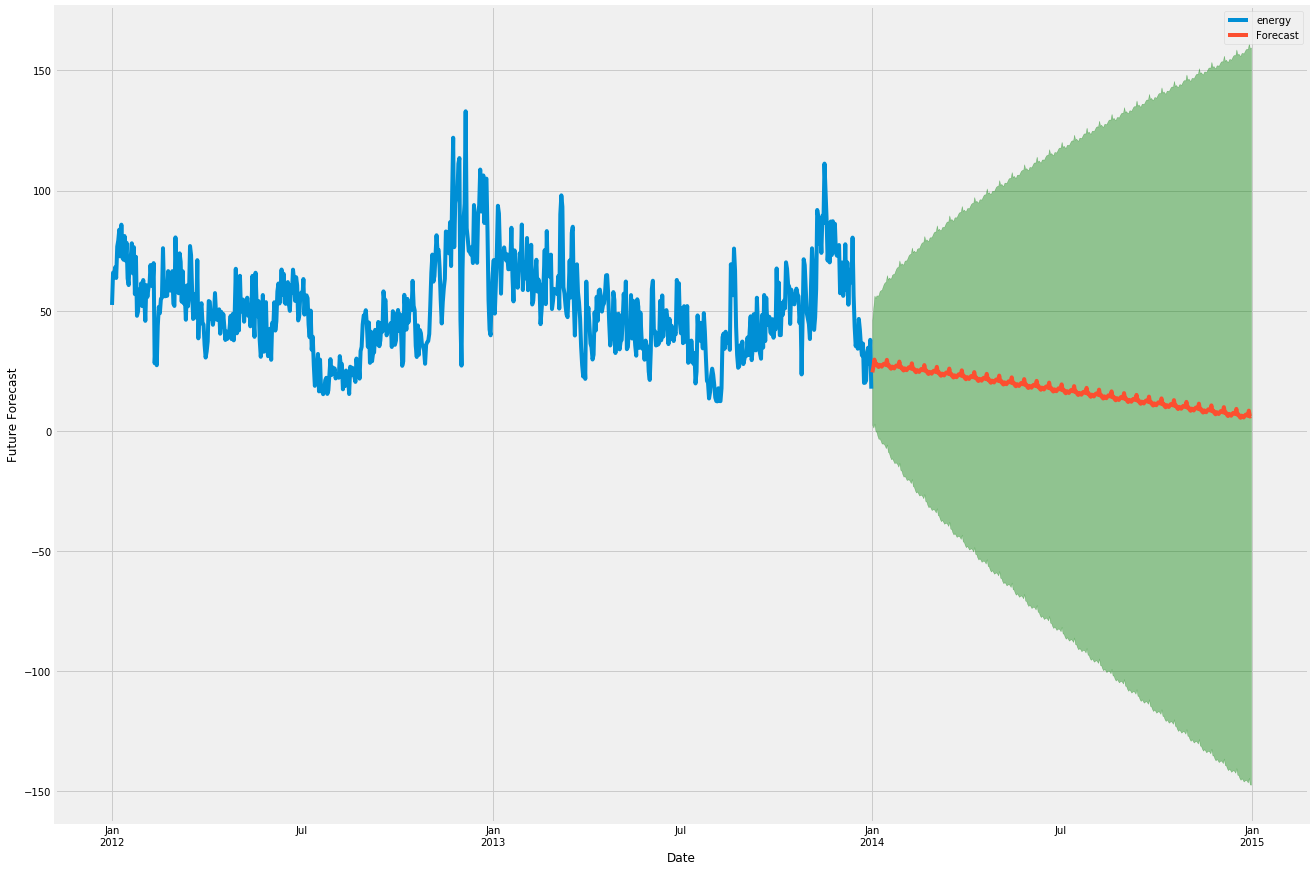

In [66]:
# FORECAST FOR 365 DAYS INTO THE FUTURE
pred_uc = results.get_forecast(steps=365)
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = high_usage.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_xlabel('Date')
ax.set_ylabel('Future Forecast')
plt.legend()
plt.show()

##### EVALUATION

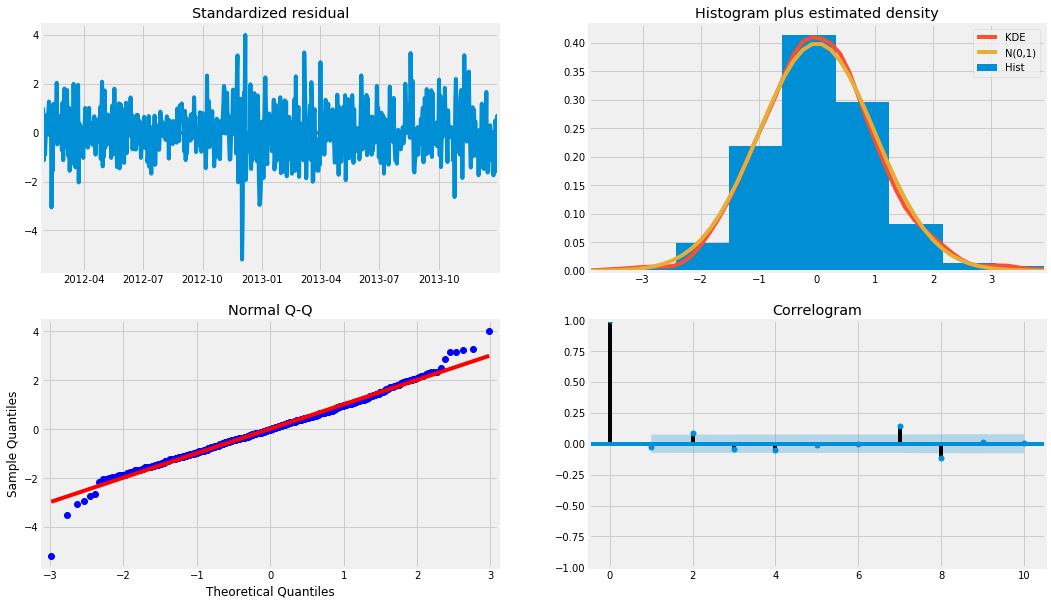

In [67]:
#PLOT THE DIAGNOSTICS FOR THE SINGLE HOUSEHOLD
results.plot_diagnostics(figsize=(16, 10))
plt.show()

In [68]:
#CALCULATE THE MEAN SQUARED ERROR
y_forecasted = pred.predicted_mean
y_truth = high_usage['2013-01-01':]
mse = mean_squared_error(y_truth, y_forecasted)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
rmse = sqrt(mse)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

MSE: 128.277
RMSE: 11.326
MAPE: 46.659


So listed are my observations for the above predictions and forecast:-

1) The model parameters were chosen based on GRIDSEARCH and the values with the lowest AIC were chosen to fit the actual data,

2) The model results summary shows the coef column which is the importance of each feature and how each one impacts the time series. The p-value tells us the significance of each feature and the values are close to 0, so it is reasonable to include the features in our model.
 
3) Next is the predictions for the complete year of 2013 with the variable "dynamic=False" where forecasts at each point are generated using the full history.

4) To make the predictions, I use get_prediction to predict the values and the Conf_int() to get the confidence interval of the predicted forecast. So in the plot "Observed Vs Precictions - Daily Data For Single Household" I can see that the predictions are close enough to the truth value and the confidence intervals shown as gray are also pretty close to the actuals.

5) For this analysis i will be forecasting for just one year which is 365 days of data and can now be used to further explore and understand the time series.As per the confidence interval the data can increase or decrease according to the seasonal patterns.

6) The residual diagnostics of the model help us in identifying if there is something in the model that could have been missed. So there are 4 plots in the diagnostics:Residual Line Plot, Residual Histogram, QQ PLot and a Correlogram.
 
7) Th Residual Line Plot looks like white noise and there is no trend that can be extracted from the residuals so this is good indication that the model is fit.

8) The histogram and the qqplot show a normal distribution, especially the qqplot looks linear.

9) The  correlelogram shows that the time series residuals have low correlation with lagged versions of itself.

###  TIMESERIES FORECASTING - DAILY OVERALL FOR 2012 and 2013

Similar to a timeseries for a single household, i have consolidated the data to run a forecast for the overall daily data of all households together. This is to help understand the overall consumption.

The same steps of analysis have been used for this too and it will be a SEASONAL ARIMA MODEL.

In [69]:
#PROCESS FOR TIMESERIES - OVERALL DAILY DATA FOR ALL HOUSEHOLDS
#INDEX FOR TIMESERIES BY THE DATA COLUMNS
daily_global = daily_data_pd[['date','energy']]
daily_global['date'] = daily_global['date'].astype('datetime64[D]')
daily_global = daily_global.set_index('date')
daily_global.head()

energy
date                 
2012-01-01  12.490646
2012-01-02  12.803507
2012-01-03  12.768018
2012-01-04  12.788858
2012-01-05  12.895683

Text(0, 0.5, 'Energy Usage')

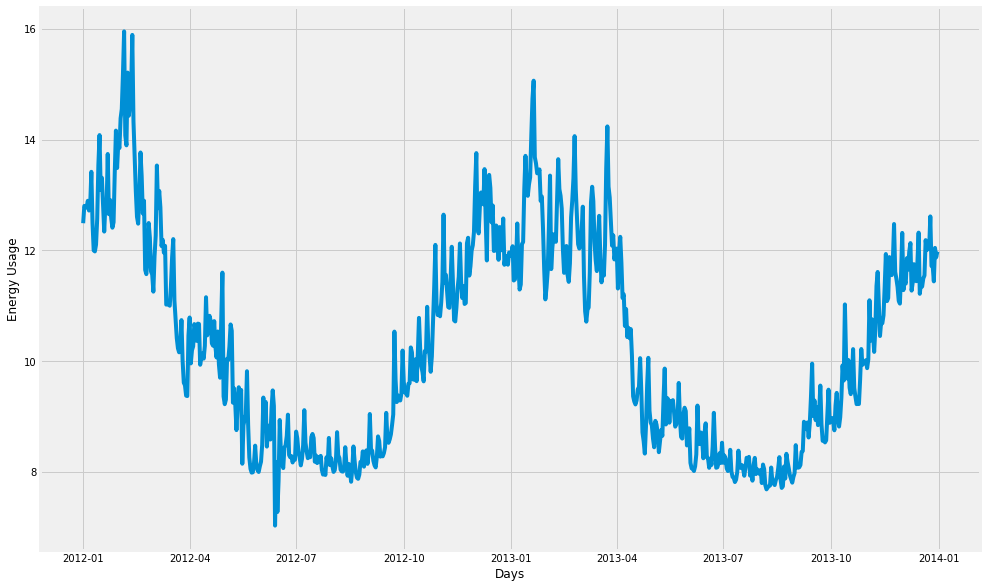

In [70]:
#PLOT THE ENERGY DATA FOR THE SINGLE HOME
plt.figure(figsize=(15, 10))
plt.plot(daily_global)
plt.xlabel('Days')
plt.ylabel('Energy Usage')

From looking at the plot i see that the overall trend seems to be decreasing when compared to the previous years. Although i do see the seasonal pattern of spikes in winter when compared to the other seasons, which is the same pattern i saw when predicting for  single household.

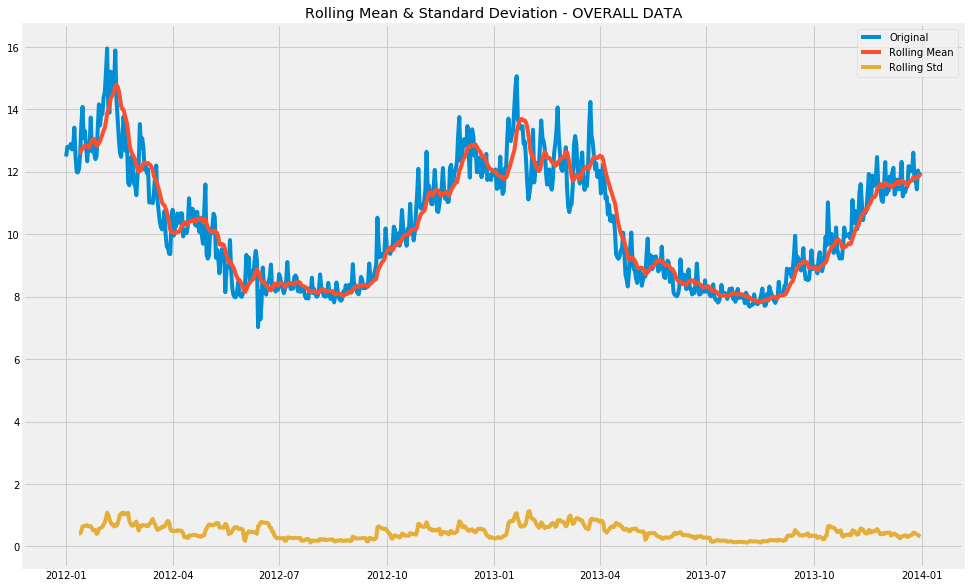

In [71]:
#CHECK IF THE DATA IS STATIONARY - PLOT BY ROLLING STATISTICS
rollingmean = daily_global.rolling(window=12).mean()
rollingstd = daily_global.rolling(window=12).std()

#Plot rolling statistics:
plt.figure(figsize=[15,10])
orig = plt.plot(daily_global, label='Original')
mean = plt.plot(rollingmean, label='Rolling Mean')
std = plt.plot(rollingstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation - OVERALL DATA')
plt.show(block=False)

In [72]:
#DICKER FULLER TEST - #VERIFY THE TS IS NON_STATIONARY
rp = daily_global['energy']
print("Results for the Dicker Fuller Test:")
dfullert = adfuller(rp,autolag='AIC')
dfullerout = pd.Series(dfullert[0:4],index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dfullert[4].items():
    dfullerout['Critical Value (%s)'%key] = value
print(dfullerout)

Results for the Dicker Fuller Test:
Test Statistic                  -2.030166
p-value                          0.273505
#lags Used                      14.000000
Number of Observations Used    716.000000
Critical Value (1%)             -3.439516
Critical Value (5%)             -2.865585
Critical Value (10%)            -2.568924
dtype: float64


From the plot i can that the mean is moving along with the original values and also looking at the Dickey Fuller Test, the test statistic is greater than the critical values which implies that the time series is non stationary.

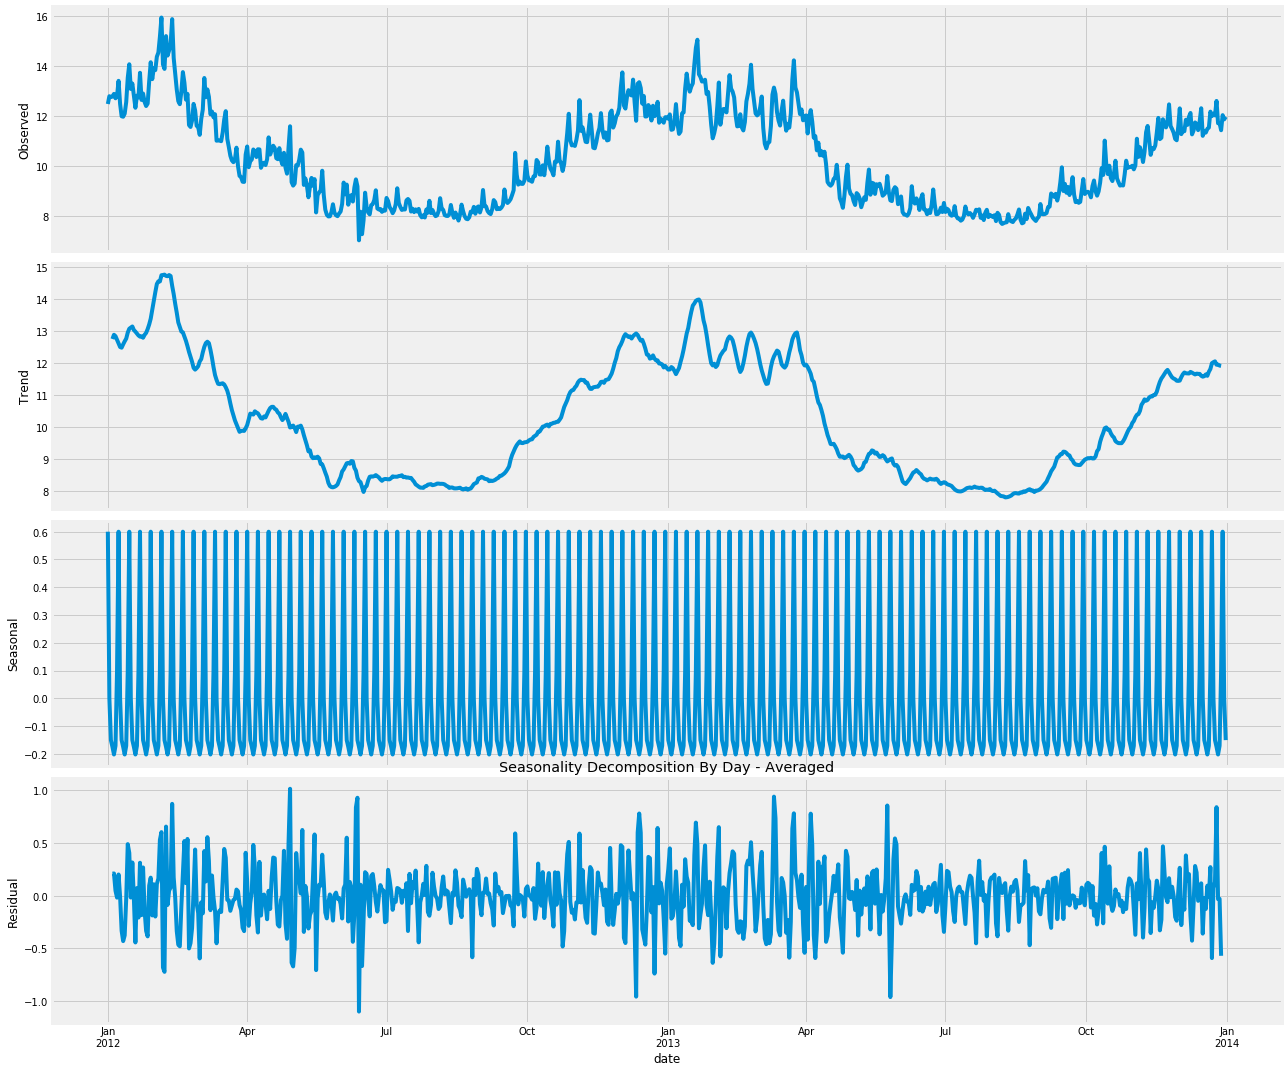

In [73]:
#SEASONALITY DECOMPOSITION FOR OVERALL DAILY DATA FROM THE HOUSEHOLDS
rcParams['figure.figsize'] = 18, 15
result = seasonal_decompose(daily_global,model='additive')
fig = result.plot()
plt.title('Seasonality Decomposition By Day - Averaged')
plt.show()

The trend is decreasing when compared to the previous years and the seasonality component does not change on a weekly or monthly or quarterly basis and remains constant across the days.

The Residuals do not show any obvious pattern or trend and look more random from the visuals.

Text(0, 0.5, 'Differenced Log (Energy Usage)')

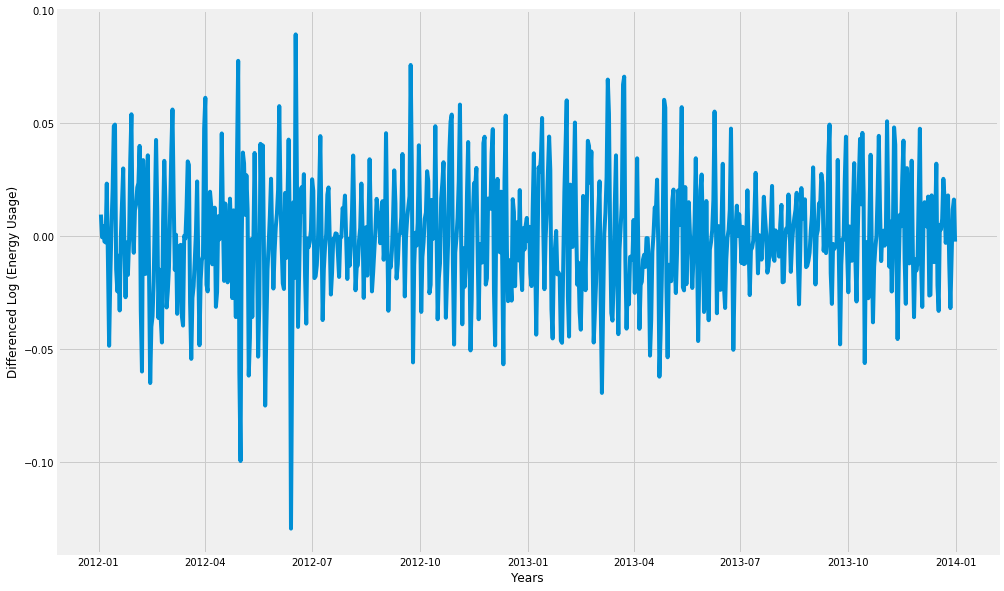

In [74]:
#PLOT AFTER APPLYING DIFFERENCING AND LOGTRANSFORM FOR STATIONARY
plt.figure(figsize=(15, 10))
plt.plot(np.log10(daily_global).diff(periods=2))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Energy Usage)')

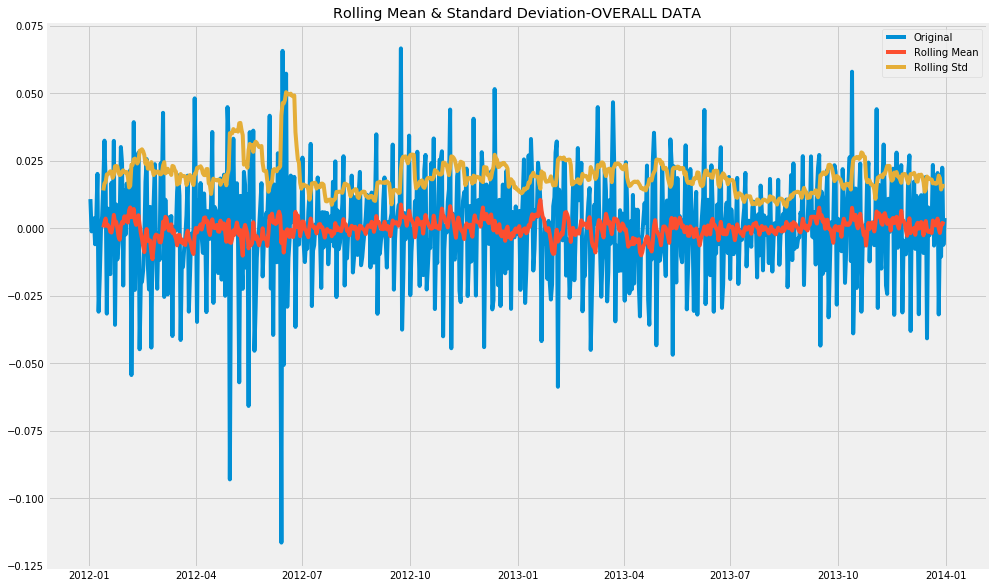

In [75]:
#CHECK IF THE DATA IS STATIONARY - PLOT BY ROLLING STATISTICS
daily_global_diff = np.log10(daily_global).diff(periods=1)
rollingmean = daily_global_diff.rolling(window=12).mean()
rollingstd = daily_global_diff.rolling(window=12).std()

#Plot rolling statistics:
plt.figure(figsize=[15,10])
orig = plt.plot(daily_global_diff, label='Original')
mean = plt.plot(rollingmean, label='Rolling Mean')
std = plt.plot(rollingstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation-OVERALL DATA')
plt.show(block=False)

This looks more stationary than when the differencing or log transform was not applied.The mean and std look more constant over time and do not seem to increase over time.

As the data is stationary, i will go ahead to check if it is an AR or MA, using the ACF and PACF functions.

In [76]:
#LOG TRANSFORM AND DIFFERENCING - TO MAKE MEAN AND VARIANCE CONSTANT
daily_global_log_diff = np.log10(daily_global).diff(periods=2)
daily_global_log_diff.dropna(inplace=True)

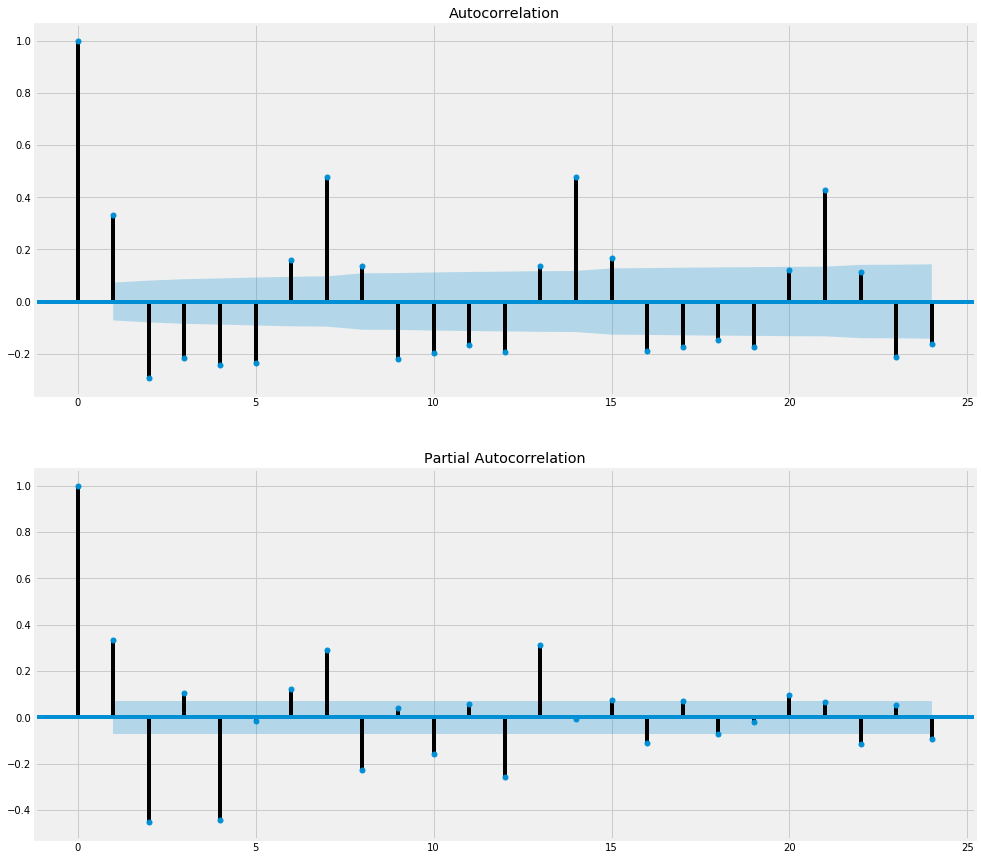

In [77]:
#Plot ACF and PACF to identify potential AR and MA model
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(daily_global_log_diff, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(daily_global_log_diff, lags=24, ax=ax2) 

From the PACF plot, i am able to identify that it is an AR as the lags seem to tail off gradually. But i dont see a seasonality from both the plots.
From the ACF plot, i can also see that for every 6 lags there is a spike which indicates there could be a MA and as it also slowly tails off towards the end.

From ACF and PACF i think we have ARMA, but i will have to use GRIDSearch to find the best parameters that would fit my SARIMA model.

In [78]:
#LOG TRANSFORM 
daily_global_log = np.log10(daily_global)
daily_global_log.dropna(inplace=True)

In [79]:
#DEFINE P,D and Q VALUES FOR THE ARIMA MODEL
p = d = q = range(0,3)

#GENERATE ALL COMBINATIONS OF P,D AND Q
pdq = list(itertools.product(p,d,q))

#GENERATE ALL COMBINATIONS FOR SEASONAL P,D AND Q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
#FOR OVERALL DAILY OVERALL DATA THE TIMESERIES ANALYSIS - FOR GLOBAL 
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(daily_global,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

           
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue
print("Best Parameters{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

In [80]:
#FIT THE MODEL FOR A SINGLE HIGH USAGE HOUSEHOLD
param_order = (1, 1, 2)
param_seasonal_order = (2, 0, 2, 12)
mod_h = sm.tsa.statespace.SARIMAX(daily_global,
                                order=param_order,
                                seasonal_order=param_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_g = mod_h.fit()
print("Blog Parameters{}x{}12 model - AIC:{}".format(param_order, param_seasonal_order, results_g.aic))

Blog Parameters(1, 1, 2)x(2, 0, 2, 12)12 model - AIC:862.4993846424038


In [81]:
print(results_g.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             energy   No. Observations:                  731
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -423.250
Date:                            Mon, 10 Dec 2018   AIC                            862.499
Time:                                    19:04:43   BIC                            898.942
Sample:                                01-01-2012   HQIC                           876.584
                                     - 12-31-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2430      0.235     -1.033      0.302      -0.704       0.218
ma.L1         -1.5812      0.174   

In [82]:
#GET THE PREDICTIONS FOR THE YEAR 2013
pred = results_g.get_prediction(start='2013-01-01', dynamic=False)
pred_ci = pred.conf_int()

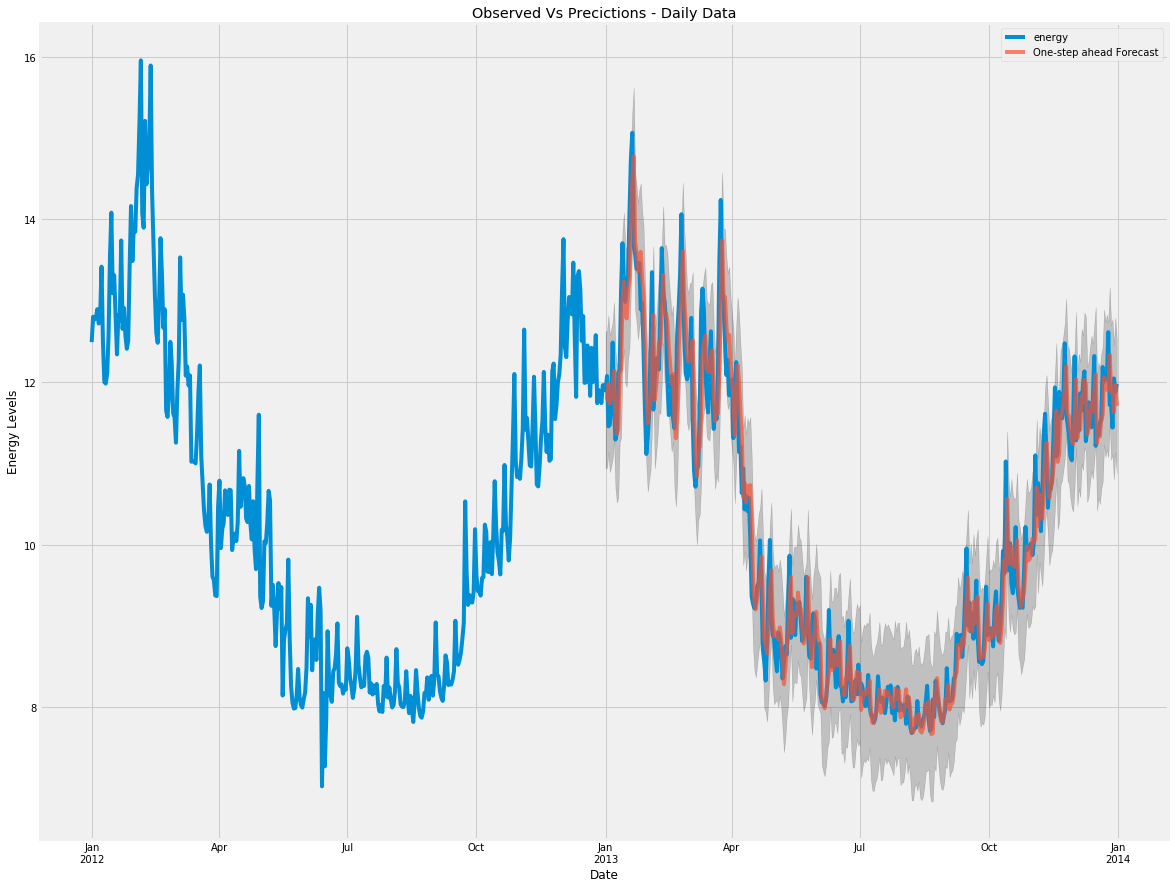

In [83]:
#PLOT THE OBSERVED AND THE PREDICTED VALYES
ax = daily_global['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)


ax.set_xlabel('Date')
ax.set_ylabel('Energy Levels')
plt.legend()
plt.title('Observed Vs Precictions - Daily Data')
plt.show()

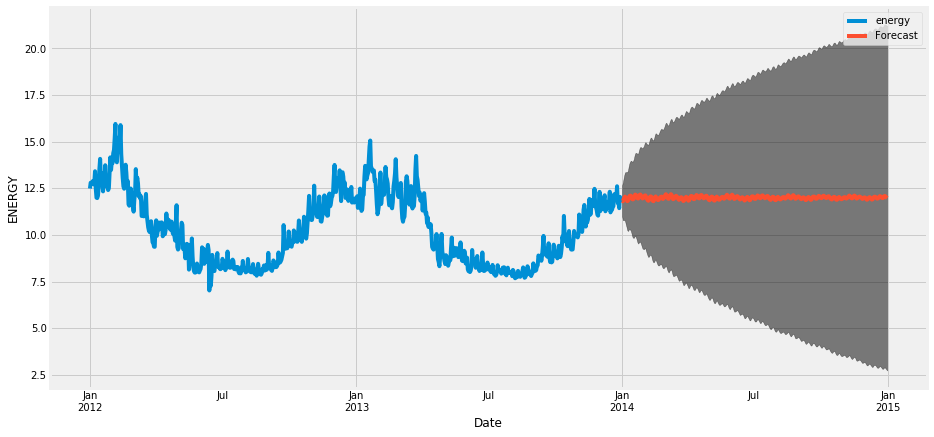

In [84]:
# FORECAST FOR 365 DAYS
pred_uc = results_g.get_forecast(steps=365)
pred_ci = pred_uc.conf_int()

ax = daily_global.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.5)
ax.set_xlabel('Date')
ax.set_ylabel('ENERGY')
plt.legend()
plt.show()

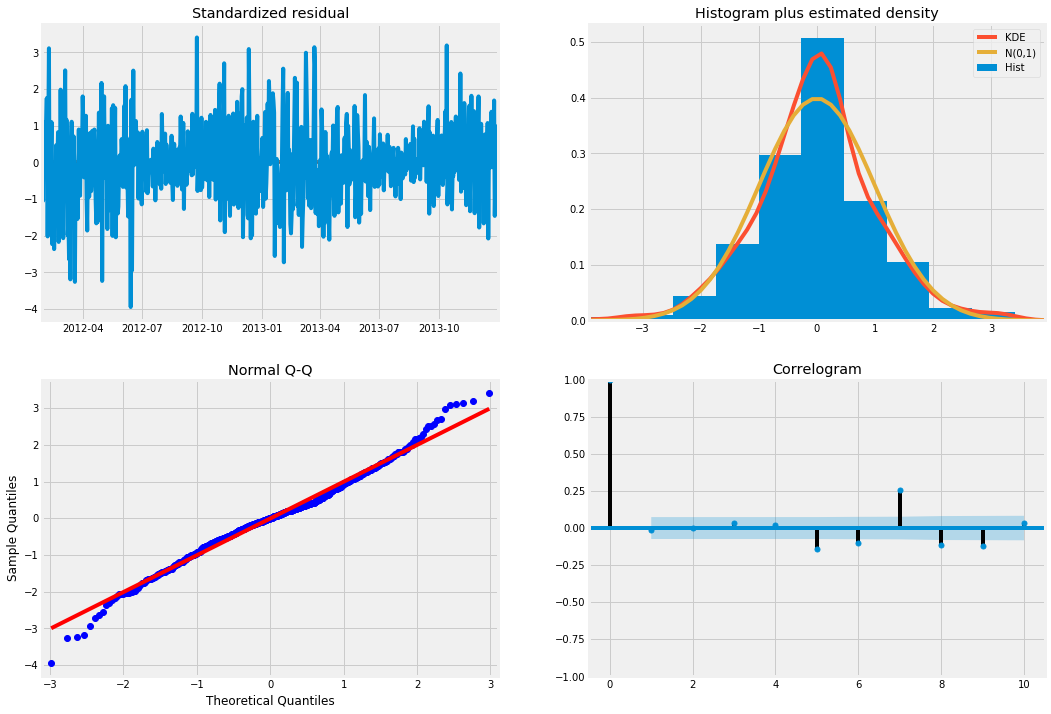

In [85]:
#PLOT THE DIAGNOSTICS
results_g.plot_diagnostics(figsize=(16, 12))
plt.show()

In [86]:
#CALCULATE THE MEAN SQUARED ERROR
y_forecasted = pred.predicted_mean
y_truth = daily_global['2013-01-01':]
mse = mean_squared_error(y_truth, y_forecasted)
mape = mean_absolute_percentage_error(y_truth, y_forecasted)
rmse = sqrt(mse)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)
print('MAPE: %.3f' % mape)

MSE: 0.165
RMSE: 0.406
MAPE: 20.490


So listed are my observations for the above predictions and forecast:-

1) A similar approach was followed for the daily overall data were model parameters were chosen using gridsearch.
 
2) The predictions were for the complete year of 2013 with the variable "dynamic=False" where forecasts at each point are generated using the full history.

3) From the predictions made I can see that the predictions are close enough to the truth value and the confidence intervals shown as gray are also pretty close to the actuals.

4) Similar to the single household data i will be forecasting for just one year which 365 days of data and can now be used to further explore and understand the time series.As per the confidence interval the data can increase or decrease according to the seasonal patterns.

5) From the residual plots i can infer that the Residual Line Plot looks like white noise and there is no trend that can be extracted from the residuals so this is good indication that the model is fit.

8) The histogram and the qqplot show a normal distribution, especially the qqplot looks linear.

9) But the correlelogram shows that the time series residuals has one lagged version which shows that is still some data that can be extracted, which may require some more fine tuning and re-model with newer parameters to bring the correlation closer to 0.

## CONCLUSION

To conclude this analysis, i was able to load the dataset, convert it to a timeseries, checked whether the series was stationary or not, applied statistics test to validate the stationary series,transformed time series to stationary using differencing and log transform, used grid search to find optimal parameters and  build SARIMA model, diagnosing time series prediction, validating the predictive power and forecasting for the next 365 days of energy consumption.

From my analysis i was able to do the below listed which are in sync with my solution:

•	Customer Segments by Electricity Consumption

•	Forecasts for House Hold Consumption by daily usage 

•	Proof that there a correlation between weather and electricity usage

NEXT STEPS:

1) Combine the Population Categories data, weather and holidays to see if i can build an explanatory model for timeseries and predict energy consumption based on this data.

2) Multiclass Classification to predict which houses will use high usage based on the days. Some of the work is already listed below.